Below is some prewritten code for diagnostic plots

In [ ]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type
import statsmodels
import statsmodels.formula.api as smf
import pandas as pd

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

I'm using SSC 2022 ICU physician performance evaluation [dataset](https://ssc.ca/en/case-study/developing-a-physician-performance-model-critical-care-assessing-quality-and-value)

Description of dataset is [here](https://docs.google.com/spreadsheets/d/1T-iGgJ_B5cnAwmdyTWxvhkULpo8c8u95/edit#gid=902028303)

Dataset has a set of patients that got into ICU and are assigned to some physician. We have specifics of each patient (age, ICU department...) and specifics of each physician. We also have daily timeseries of how treatment affected patient's status over time, including final result (dead/alive).

Lastly, we have detailed questionnaire (called 360 evaluation) filled by nurses/allied physicians about each physician, where physician is evaluated on different skills. We also have overall score of physician by respective patients.

Main goal of the competition was to evaluate physicians, and there is a variety of possibilities for that. I'm more focused on predicting survival rate of each patient.

**Q1** Describe and justify two different topics or approaches you might want to consider for this dataset and task. You don't have to use these tasks in the actual analysis.

1) Its interesting to study relationship between patient/physician and mortality rate. For patient, we could see how age/initial score/diagnosis/ICU department correlates with mortality rate. For physician, we could see how 360 evaluation questions/education degree/rank correlates with mortality rate. Each feature may be interesting to investigate on its own, so there are multiple questions that can be answered here. As an example, we could see which questions in 360 evaluation correlate with mortality the most, or if some other mentioned features like degree explain statistically significant variance when combined with 360 evaluation, or if 360 evaluation has enough information on its own. Its important to mention that if we put all features in one model, we most likely will have a lot of correlated features, so ElasticNet kind of regularization should be useful (so that we can select model based on Lasso and get rid of correlation with Ridge). 

2) At [SOFA wiki page](https://en.wikipedia.org/wiki/SOFA_score) and [reference](https://jamanetwork.com/journals/jama/fullarticle/194262) it says that mortality rate can be more accurately predicted based on SOFA score change in the first 96 hours. We can check whether its true for our data. In general, we may study how SOFA score changes based on specific features like ICU department and physician. We may also study if length of stay and average change in SOFA score day-by-day (fluctuations of the score) correlates with mortality rate.

3) We may study distribution of length of stay/mortality with respect to ICU department. We may see that some departments have low mortality rate in general, or mortality rate depends on combination of department and diagnosis.

**Q2** Describe and show the code used to clean and collect the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_doctors = pd.read_csv('df_doctors.csv')
df_doctors


,DocID,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,doc-01,2+,leader_x,senior,4.033301,2,F,anesthesia,50+,NaN
1,doc-02,2+,leader_x,senior,4.483527,2,M,internal medicine,50+,MSc
2,doc-03,2+,leader_x,junior,4.256743,2,F,pulmonary medicine,<50,PhD
3,doc-04,1,leader,junior,4.175182,3,F,emergency,<50,NaN
4,doc-05,1,leader_x,junior,5.610845,1,M,internal medicine,50+,MMed
5,doc-06,2+,leader,senior,5.737756,2,M,medicine,50+,MSc
6,doc-07,1,leader_x,junior,5.186852,2,M,internal medicine,<50,NaN
7,doc-08,1,leader_x,senior,4.240653,2,F,pulmonary medicine,<50,NaN
8,doc-09,1,leader_x,junior,3.995118,2,F,internal medicine,50+,NaN
9,doc-10,1,leader_x,junior,4.726975,3,M,internal medicine,50+,NaN


In [ ]:
# rename df_doctors
df = df_doctors.loc[:, ['DocID']]
df['is_multiple_isu'] = (df_doctors['M1'] == '2+')
df['is_leader'] = (df_doctors['M2'] == 'leader')
df['is_senior'] = (df_doctors['M3'] == 'senior')
df['survey_score'] = df_doctors['M4']
df['resident_ranking'] = df_doctors['M5']
df['is_male'] = (df_doctors['M6'] == 'M')
df['background_domain'] = df_doctors['M7']
df['is_50_older'] = (df_doctors['M8'] == '50+')
df['university_degree'] = df_doctors['M9'].fillna('NA')
df = df * 1
df_doctors = df
df_doctors

,DocID,is_multiple_isu,is_leader,is_senior,survey_score,resident_ranking,is_male,background_domain,is_50_older,university_degree
0,doc-01,1,0,1,4.033301,2,0,anesthesia,1,NA
1,doc-02,1,0,1,4.483527,2,1,internal medicine,1,MSc
2,doc-03,1,0,0,4.256743,2,0,pulmonary medicine,0,PhD
3,doc-04,0,1,0,4.175182,3,0,emergency,0,NA
4,doc-05,0,0,0,5.610845,1,1,internal medicine,1,MMed
5,doc-06,1,1,1,5.737756,2,1,medicine,1,MSc
6,doc-07,0,0,0,5.186852,2,1,internal medicine,0,NA
7,doc-08,0,0,1,4.240653,2,0,pulmonary medicine,0,NA
8,doc-09,0,0,0,3.995118,2,0,internal medicine,1,NA
9,doc-10,0,0,0,4.726975,3,1,internal medicine,1,NA


In [ ]:
df.describe(include='all')

,DocID,is_multiple_isu,is_leader,is_senior,survey_score,resident_ranking,is_male,background_domain,is_50_older,university_degree
count,25,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25,25.00000,25
unique,25,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,4
top,doc-01,NaN,NaN,NaN,NaN,NaN,NaN,internal medicine,NaN,NA
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,15
mean,NaN,0.4,0.480000,0.480000,4.620807,2.280000,0.560000,NaN,0.76000,NaN
std,NaN,0.5,0.509902,0.509902,1.101037,0.613732,0.506623,NaN,0.43589,NaN
min,NaN,0.0,0.000000,0.000000,2.316098,1.000000,0.000000,NaN,0.00000,NaN
25%,NaN,0.0,0.000000,0.000000,3.995118,2.000000,0.000000,NaN,1.00000,NaN
50%,NaN,0.0,0.000000,0.000000,4.483527,2.000000,1.000000,NaN,1.00000,NaN
75%,NaN,1.0,1.000000,1.000000,5.431024,3.000000,1.000000,NaN,1.00000,NaN


In [ ]:
df_patients = pd.read_csv('df_patients.csv')
df_patients

,DocID,PtID,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
0,doc-01,101103,lt60,no_op,medical,1,27,11,M,A,10,cardiovascular
1,doc-01,101108,lt60,no_op,medical,3,22,5,M,A,6,cardiovascular
2,doc-01,101151,ge60,no_op,medical,3,22,5,F,A,10,cardiovascular
3,doc-01,101551,lt60,no_op,medical,3,21,6,M,A,8,cardiovascular
4,doc-01,102061,ge60,no_op,medical,2,24,6,F,A,6,cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...
2108,doc-25,501004,ge60,emerg,surgical,1,19,8,F,A,11,trauma
2109,doc-25,501056,lt60,emerg,surgical,1,17,8,M,A,0,trauma
2110,doc-25,303050,lt60,emerg,surgical,2,23,9,F,A,2,gastrointestinal
2111,doc-25,304227,lt60,emerg,medical,3,25,12,F,D,1,gastrointestinal


In [ ]:
# rename df_patients
df = df_patients.loc[:, ['DocID', 'PtID']]
df['is_60_older'] = (df_patients['P1'] == 'ge60')
df['is_emergency'] = (df_patients['P2'] == 'emerg')
df['icu_department'] = df_patients['P3']
# refer: https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci#use-cases
# predicts 10-year survival chance
df['comorbidity_index'] = df_patients['P4']
df['apache_score'] = df_patients['P5']
df['initial_sofa_score'] = df_patients['P6']
df['is_male'] = (df_patients['P7'] == 'M')
# means died at ICU discharge
df['is_dead'] = (df_patients['P8'] == 'D')
df['length_of_stay'] = df_patients['P9']
df['diagnosis'] = df_patients['P10']
df = df * 1
df_patients = df
df_patients

,DocID,PtID,is_60_older,is_emergency,icu_department,comorbidity_index,apache_score,initial_sofa_score,is_male,is_dead,length_of_stay,diagnosis
0,doc-01,101103,0,0,medical,1,27,11,1,0,10,cardiovascular
1,doc-01,101108,0,0,medical,3,22,5,1,0,6,cardiovascular
2,doc-01,101151,1,0,medical,3,22,5,0,0,10,cardiovascular
3,doc-01,101551,0,0,medical,3,21,6,1,0,8,cardiovascular
4,doc-01,102061,1,0,medical,2,24,6,0,0,6,cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...
2108,doc-25,501004,1,1,surgical,1,19,8,0,0,11,trauma
2109,doc-25,501056,0,1,surgical,1,17,8,1,0,0,trauma
2110,doc-25,303050,0,1,surgical,2,23,9,0,0,2,gastrointestinal
2111,doc-25,304227,0,1,medical,3,25,12,0,1,1,gastrointestinal


In [ ]:
df_sofa = pd.read_csv('df_traj.csv')
df_sofa

,PtID,day,SOFA
0,101008,0,7
1,101008,1,13
2,101008,2,11
3,101008,3,11
4,101008,4,8
...,...,...,...
15760,505273,11,6
15761,505273,12,5
15762,505273,13,6
15763,505273,14,3


In [ ]:
df_sofa = df_sofa.sort_values('day').groupby('PtID')['SOFA'].apply(list).to_frame('sofa_list').reset_index()
df_sofa['final_sofa_score'] = df_sofa['sofa_list'].apply(lambda x : x[-1])
df_sofa['mean_sofa_score'] = df_sofa['sofa_list'].apply(np.mean)
df_sofa['max_sofa_score'] = df_sofa['sofa_list'].apply(np.max)
df_sofa['variance_sofa_score'] = df_sofa['sofa_list'].apply(np.var)
df_sofa['48h_change_sofa_score'] = df_sofa['sofa_list'].apply(lambda x : None if len(x) < 3 else (np.max(x[1:3]) - x[0]))
df_sofa

,PtID,sofa_list,final_sofa_score,mean_sofa_score,max_sofa_score,variance_sofa_score,48h_change_sofa_score
0,101008,"[7, 13, 11, 11, 8, 10, 10, 6, 8, 9, 9, 7, 11, ...",7,8.190476,13,6.154195,6.0
1,101010,"[12, 6, 12, 8, 13, 7, 5]",5,9.000000,13,9.142857,0.0
2,101011,"[3, 5, 4, 3]",3,3.750000,5,0.687500,2.0
3,101033,"[6, 8]",8,7.000000,8,1.000000,NaN
4,101036,"[7, 10, 8, 9]",9,8.500000,10,1.250000,3.0
...,...,...,...,...,...,...,...
2108,505244,"[7, 4, 4, 5, 5, 4, 2]",2,4.428571,7,1.959184,-3.0
2109,505254,"[7, 9]",9,8.000000,9,1.000000,NaN
2110,505264,"[7, 8, 8, 7, 6, 3, 2, 3, 3, 4, 5, 3]",3,4.916667,8,4.409722,1.0
2111,505272,"[5, 2, 4, 3, 2, 3, 2]",2,3.000000,5,1.142857,-1.0


In [ ]:
df_sofa['len'] = df_sofa['sofa_list'].apply(len)
df = df_patients[['PtID', 'length_of_stay']].join(df_sofa[['PtID', 'len']].set_index('PtID'), on='PtID')
(df.length_of_stay.clip(upper=20) - df.len).value_counts()

-1    2113
dtype: int64

Above we checked, that `length_of_stay` is consistent with SOFA measurements: `length_of_stay` is one less than the number of SOFA measurements for each patient (where number of measurements is clipped by 20). This is because length of stay is the number of full days at the ICU. So we will use `length_of_stay` feature.

In [ ]:
df_eval360 = pd.read_csv('df_eval360.csv')
df_eval360

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,DocID,position
0,4.0,5.0,5.0,5.0,4.0,5.0,2,5.0,4.0,3.0,...,5.0,5.0,4.0,5.0,5.0,NaN,4.0,3.0,doc-09,bedside
1,4.0,5.0,5.0,5.0,5.0,4.0,4,3.0,5.0,5.0,...,5.0,3.0,3.0,3.0,NaN,3.0,4.0,5.0,doc-17,bedside
2,4.0,4.0,5.0,3.0,5.0,4.0,3,4.0,5.0,5.0,...,5.0,5.0,2.0,4.0,NaN,4.0,3.0,5.0,doc-15,bedside
3,5.0,5.0,5.0,5.0,4.0,4.0,3,4.0,5.0,5.0,...,5.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,doc-01,bedside
4,5.0,5.0,5.0,4.0,5.0,3.0,4,5.0,5.0,3.0,...,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,doc-05,non-bedside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,5.0,5.0,5.0,5.0,3.0,NaN,3,4.0,4.0,4.0,...,4.0,3.0,4.0,4.0,4.0,5.0,3.0,5.0,doc-15,bedside
796,5.0,4.0,NaN,5.0,5.0,5.0,3,5.0,5.0,5.0,...,2.0,4.0,5.0,3.0,5.0,4.0,5.0,5.0,doc-19,non-bedside
797,5.0,5.0,4.0,4.0,5.0,5.0,2,5.0,3.0,4.0,...,1.0,4.0,2.0,5.0,NaN,5.0,5.0,4.0,doc-15,non-bedside
798,4.0,3.0,5.0,3.0,4.0,4.0,4,5.0,3.0,5.0,...,3.0,4.0,4.0,4.0,5.0,4.0,4.0,2.0,doc-14,bedside


Lastly, we have 360 evaluation dataset. I've worked a lot on it's own with it, but there were almost no interesting results to discuss.

My main conclusion was that since survey 360 has 23 questions, it will be useful to reduce number of dimensions, which I did with PCA. This code will be below. Other part of analysis of 360 survey will be present in **Appendix** at the bottom of this notebook.

<ipython-input-11-1c4493dcb7ee>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  X = df_eval360.groupby('DocID').mean()


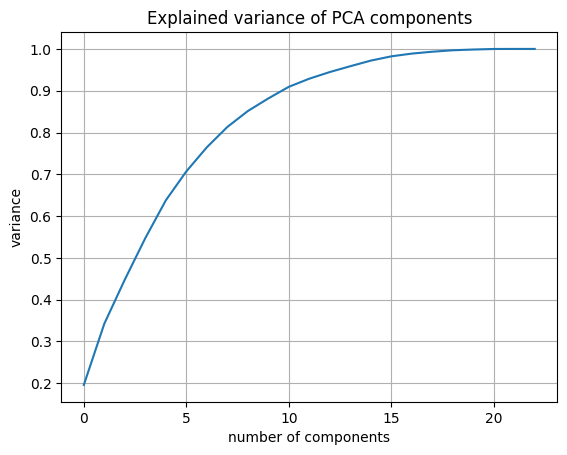

In [ ]:
from sklearn.decomposition import PCA

X = df_eval360.groupby('DocID').mean()

pca = PCA()
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance of PCA components')
plt.xlabel('number of components')
plt.ylabel('variance')
plt.grid()
plt.show()

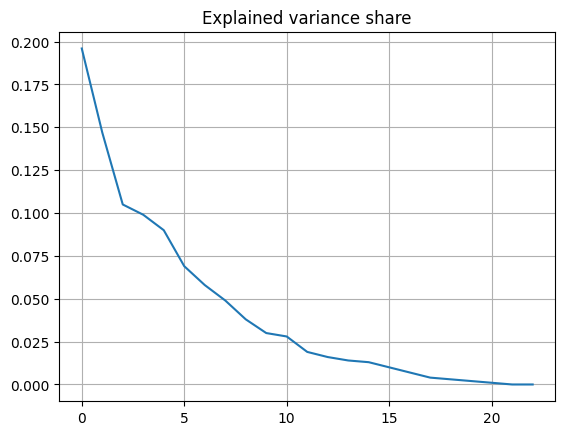

In [ ]:
plt.plot(np.round(pca.explained_variance_ratio_, 3))
plt.title('Explained variance share')
plt.grid()
plt.show()

In [ ]:
print('cumulative explained variance', list(np.round(np.cumsum(pca.explained_variance_ratio_), 3)[:10]))
print('individual component explained variance', list(np.round(pca.explained_variance_ratio_, 3)[:10]))

cumulative explained variance [0.196, 0.343, 0.448, 0.547, 0.638, 0.707, 0.765, 0.813, 0.851, 0.882]
individual component explained variance [0.196, 0.147, 0.105, 0.099, 0.09, 0.069, 0.058, 0.049, 0.038, 0.03]


Let's take 5 components, which explains 64% of variance.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), index=X.index, columns=['360_0', '360_1', '360_2', '360_3', '360_4'])


In [ ]:
df_eval360_pca = X_pca
df_eval360_pca

,360_0,360_1,360_2,360_3,360_4
DocID,,,,,
doc-01,0.011492,0.136734,-0.371399,0.480578,-0.050465
doc-02,-0.010779,-0.003180,-0.030479,0.007160,0.166843
doc-03,-0.147576,0.094492,-0.139298,-0.143166,-0.190669
doc-04,-0.461763,0.214133,-0.108870,0.034898,-0.062889
doc-05,0.145112,-0.338851,-0.171705,-0.151460,-0.093058
doc-06,-0.065153,0.083558,-0.092966,-0.366969,0.070269
doc-07,0.441780,0.126513,-0.287614,0.615604,-0.017002
doc-08,0.149537,0.193307,0.231498,-0.170218,-0.397334
doc-09,0.300755,0.351563,-0.029688,-0.412116,0.243026


In [ ]:
df_doctors['background_domain'] = df_doctors['background_domain'].astype('category').cat.rename_categories({'anesthesia': 'anst', 
                                                                                          'internal medicine': 'int.med', 
                                                                                          'pulmonary medicine': 'pul.med', 
                                                                                          'medicine': 'med', 
                                                                                          'emergency': 'emg'})
df_patients['diagnosis'] = df_patients['diagnosis'].astype('category').cat.rename_categories({'cardiovascular': 'cardio',
                                                                                              'respiratory': 'resp',
                                                                                              'gastrointestinal': 'gastro',
                                                                                              'neuro': 'neuro',
                                                                                              'trauma': 'trauma'})

In [ ]:
X_doctors = df_doctors.join(df_eval360_pca, on='DocID')
X_patients = df_patients.join(df_sofa.drop(columns=['len']).set_index('PtID'), on='PtID')
data = X_patients.join(X_doctors.set_index('DocID'), on='DocID', lsuffix='_patient', rsuffix='_doc')

In [ ]:
print('shape:', data.shape)
data.isna().sum()

shape: (2113, 32)


DocID                      0
PtID                       0
is_60_older                0
is_emergency               0
icu_department             0
comorbidity_index          0
apache_score               0
initial_sofa_score         0
is_male_patient            0
is_dead                    0
length_of_stay             0
diagnosis                  0
sofa_list                  0
final_sofa_score           0
mean_sofa_score            0
max_sofa_score             0
variance_sofa_score        0
48h_change_sofa_score    398
is_multiple_isu            0
is_leader                  0
is_senior                  0
survey_score               0
resident_ranking           0
is_male_doc                0
background_domain          0
is_50_older                0
university_degree          0
360_0                      0
360_1                      0
360_2                      0
360_3                      0
360_4                      0
dtype: int64

We will be studying mortality, I think it is better to predict it independently for each patient (based on the fact that we have only 25 physicians, and my 360 survey didn't go well).

In [ ]:
data.dtypes

DocID                      object
PtID                        int64
is_60_older                 int64
is_emergency                int64
icu_department             object
comorbidity_index           int64
apache_score                int64
initial_sofa_score          int64
is_male_patient             int64
is_dead                     int64
length_of_stay              int64
diagnosis                category
sofa_list                  object
final_sofa_score            int64
mean_sofa_score           float64
max_sofa_score              int64
variance_sofa_score       float64
48h_change_sofa_score     float64
is_multiple_isu             int64
is_leader                   int64
is_senior                   int64
survey_score              float64
resident_ranking            int64
is_male_doc                 int64
background_domain        category
is_50_older                 int64
university_degree          object
360_0                     float64
360_1                     float64
360_2         

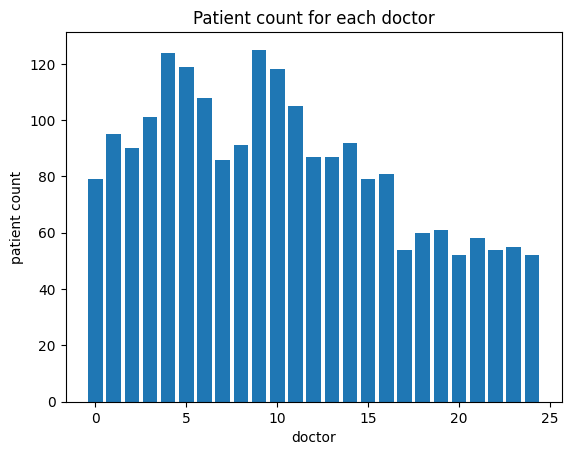

In [ ]:
plt.bar(range(25), data.groupby('DocID')['PtID'].count())
plt.title('Patient count for each doctor')
plt.xlabel('doctor')
plt.ylabel('patient count')
plt.show()

Seems like patients are more or less evenly distributed to doctors.

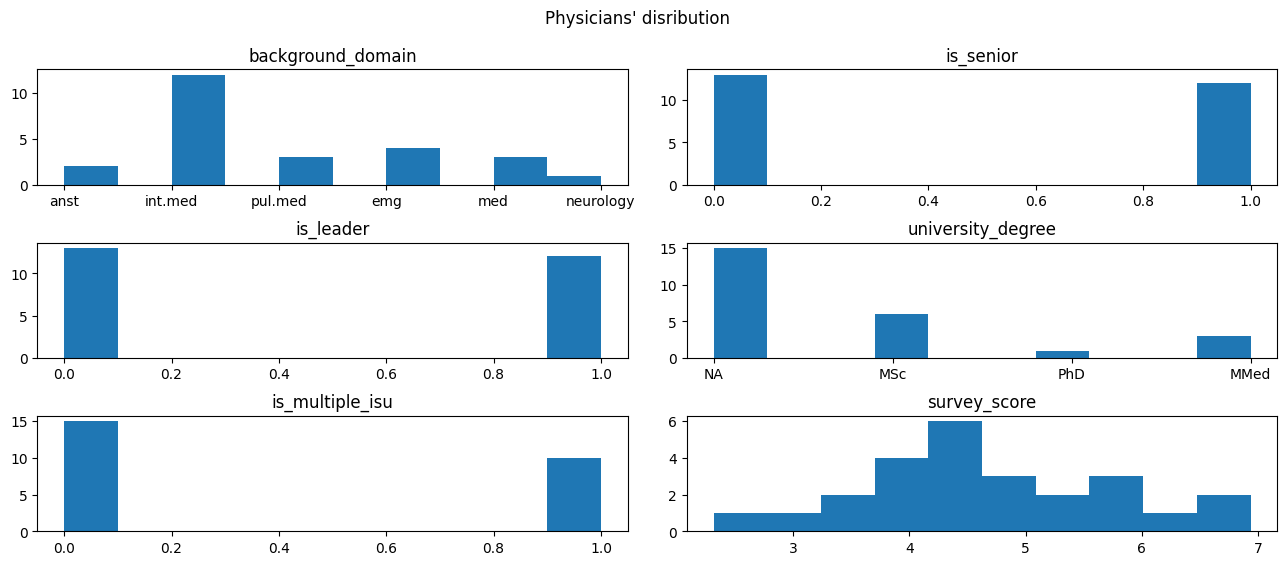

In [ ]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=.5, wspace=.1)
i = 0
for col in ['background_domain', 'is_senior', 'is_leader', 'university_degree', 'is_multiple_isu', 'survey_score']:
  i += 1
  ax = fig.add_subplot(3, 2, i)
  ax.set_title(col)
  ax.hist(X_doctors[col])
  # plt.show()
fig.suptitle('Physicians\' disribution')
fig.show()

**Q3** Give a ggpairs plot of what you think are the six most important variables. At least one must be categorical, and one continuous. Explain your choice of variables and the trends between them. 

There is no decent open source ggpairs for python, so I wrote my own.

In [ ]:
def is_categorical(s):
  return len(s.unique()) <= 4 or (s.dtype != float and s.dtype != int)

def my_ggpairs(X, columns, ss_size=1000):
  cols = columns
  L = len(cols)
  fig = plt.figure(figsize=(16, 13))
  fig.subplots_adjust(hspace=.4, wspace=.2)
  for i in range(L):
    for j in range(L):
      # ax.set_title(col)
      if i == j:
        # frequency of i
        sns.histplot(x=X[cols[i]], ax=ax)
      elif not is_categorical(X[cols[i]]):
        # i numerical
        if not is_categorical(X[cols[j]]):
          # j numerical, scatterplot
          if i < j:
            sns.scatterplot(x=X[cols[j]], y=X[cols[i]], ax=ax)
          else:
            sns.scatterplot(x=X[cols[j]], y=X[cols[i]], ax=ax)
        else:
          # i numerical, j categorical
          sns.boxplot(
              data=X, y=cols[i], x=cols[j],
              ax=ax
          )
          # sns.violinplot(
          #     data=X, y=cols[i], x=cols[j],
          #     bw=.25, cut=0, split=True,
          #     ax=ax
          # )
      elif is_categorical(X[cols[j]]):
        # i categorical, j categorical
        sns.histplot(x=X[cols[j]].astype('category'), hue=X[cols[i]], ax=ax, multiple='dodge', shrink=0.8)
      else:
        # i categorical, j numerical
        sns.stripplot(x=X[cols[i]], y=X[cols[j]], ax=ax)
      ax.set(xlabel=None, ylabel=None)
      if i == L - 1:
        ax.set_xlabel(cols[j])
      if j == 0:
        ax.set_ylabel(cols[i])
      if j == L - 1:
        ax.set_ylabel(cols[i])
        ax.yaxis.set_label_position('right')
      if i == 0:
        ax.set_xlabel(cols[j])
        ax.xaxis.set_label_position('top') 
      leg = ax.get_legend()
      if leg is not None:
        leg.remove()
      try:
        float(ax.get_xticklabels()[-1].get_text())
      except Exception as e:
        ax.xaxis.set_tick_params(rotation=-40)
  fig.tight_layout()
  fig.show()

In [ ]:
# X = X_doctors

# X = X.set_index('DocID')
# X['death_ratio'] = X_patients.groupby('DocID')['is_dead'].mean()
# my_ggpairs(X, ['is_leader', 'is_senior', 'background_domain', 'university_degree', 'survey_score', 'death_ratio'])

In [ ]:
data.columns

Index(['DocID', 'PtID', 'is_60_older', 'is_emergency', 'icu_department',
       'comorbidity_index', 'apache_score', 'initial_sofa_score',
       'is_male_patient', 'is_dead', 'length_of_stay', 'diagnosis',
       'sofa_list', 'final_sofa_score', 'mean_sofa_score', 'max_sofa_score',
       'variance_sofa_score', '48h_change_sofa_score', 'is_multiple_isu',
       'is_leader', 'is_senior', 'survey_score', 'resident_ranking',
       'is_male_doc', 'background_domain', 'is_50_older', 'university_degree',
       '360_0', '360_1', '360_2', '360_3', '360_4'],
      dtype='object')

I first examine patient features only.

I want to make 2 pairs plot, first will be mostly for continious features. From plots below it should be evident, that it is enough to leave only 1 continous variable, so we will first choose which one, then build second pairs plot.


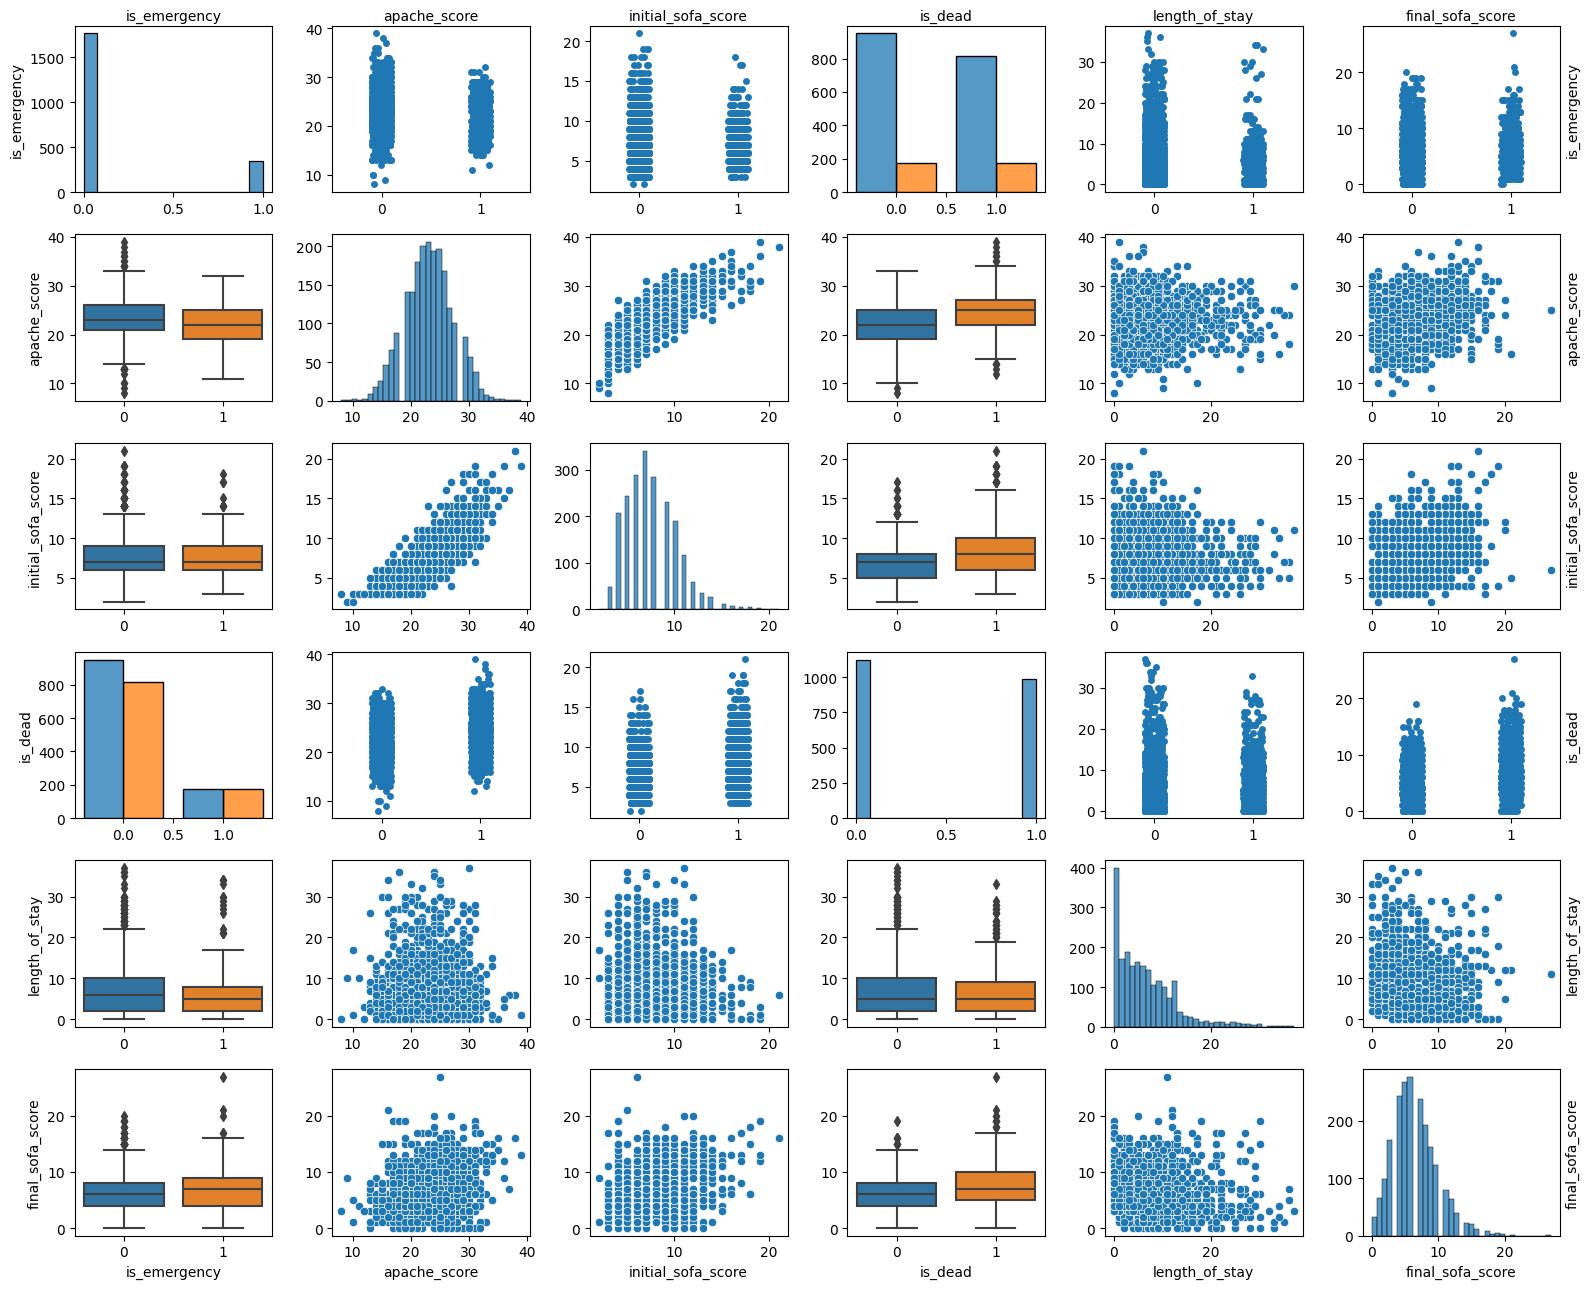

In [ ]:
# continious
my_ggpairs(data, [
            'is_emergency',
            'apache_score', 
            'initial_sofa_score', 
            'is_dead', 
            'length_of_stay', 
            'final_sofa_score', 
            ], ss_size=100)


Note: there are skipped bars in some frequency plots, this is artifact (perhaps because of integers), ignore them.

* apache and initial sofa score are positively correlated
* higher initial sofa score leads to higher chance of death
* combination of previous two: higher apache score leads to higher chance of death
* scatterplot of length of stay is right skewed w.r.t. initial sofa score. Together with one of previous points we may suggest that high sofa score likely leads to sudden death and hence short stay
* initial sofa score is seemingly unrelated to final sofa score, which is strange. Looks like final sofa score is useless
* for patients that remain alive compared to dead: length of stay distribution has longer tail
* apache score has normal distribution, sofa score is right skewed

Based on above, I will take apache score as the only continious variable onwards
 

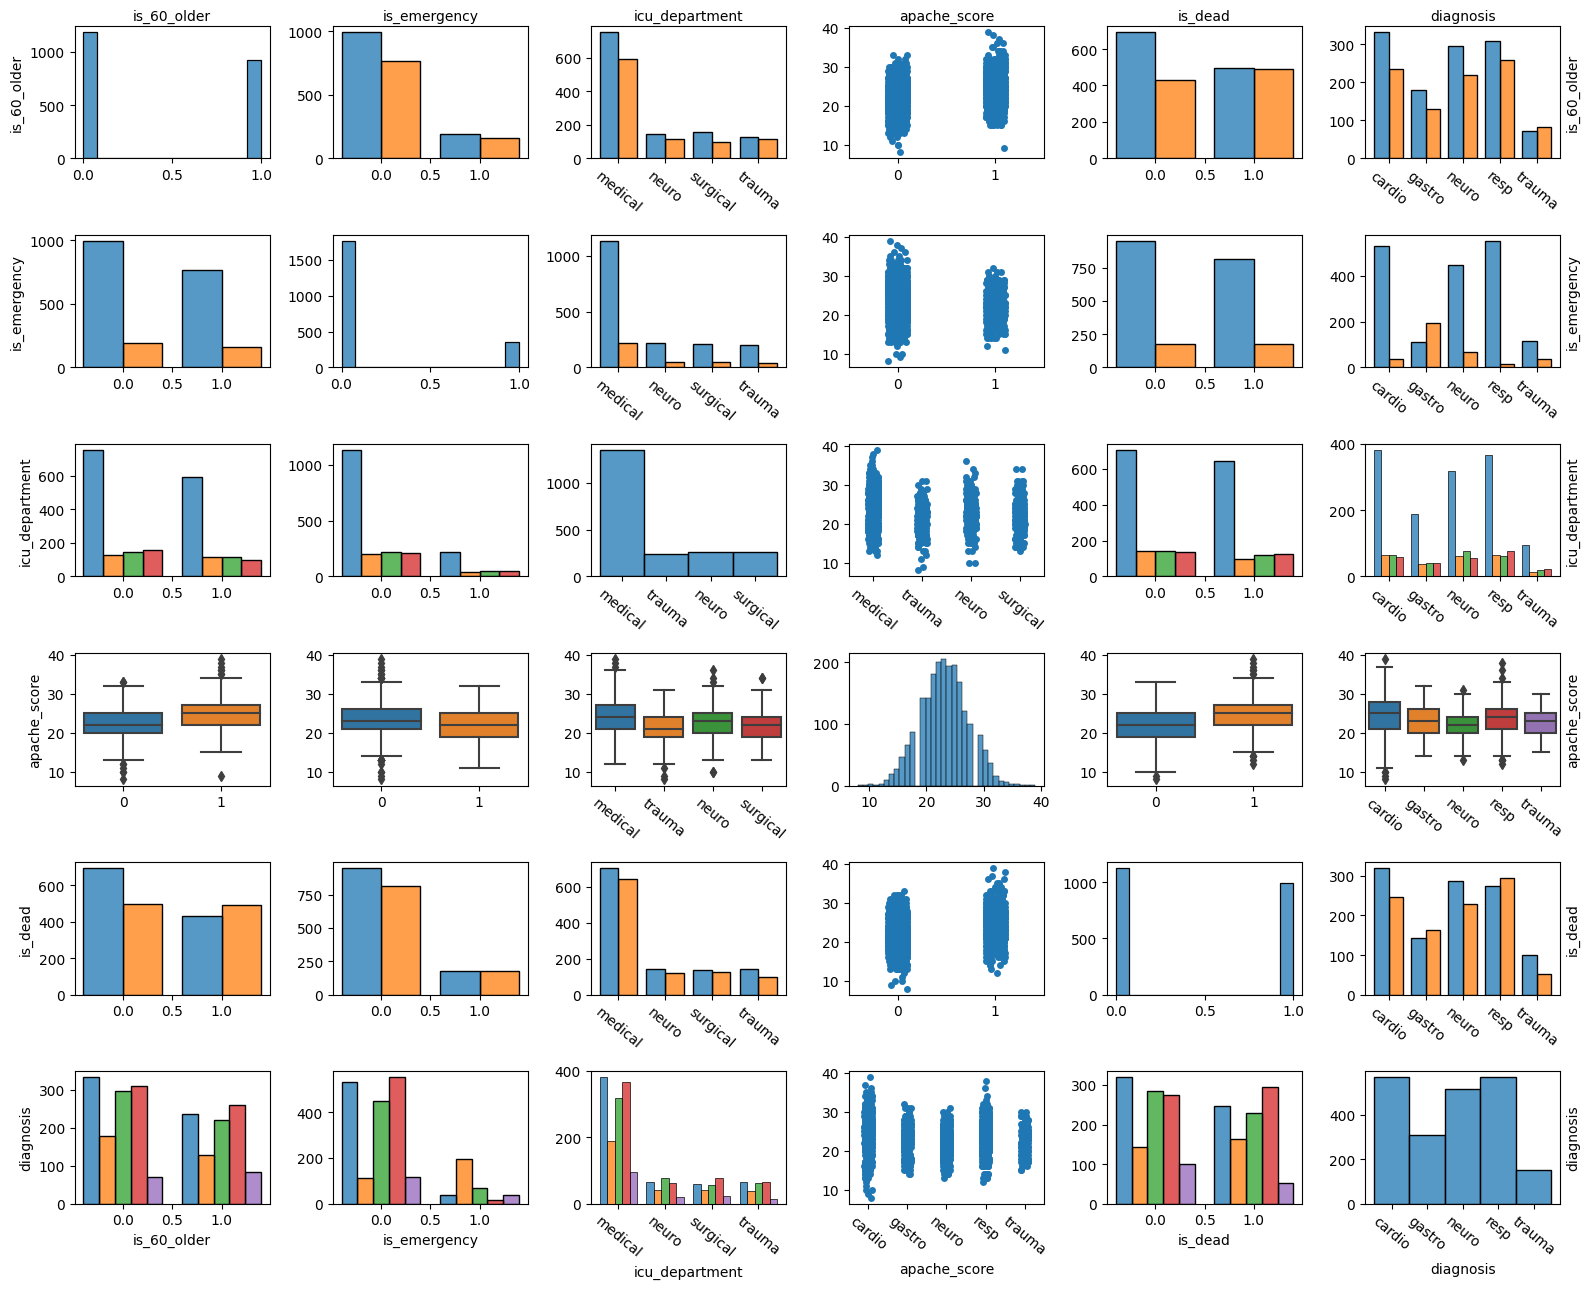

In [ ]:
# mix
my_ggpairs(data, [
            'is_60_older', 
            'is_emergency', 
            'icu_department', 
            'apache_score', 
            'is_dead', 
            'diagnosis', 
            ], ss_size=100)


* older people (60+) compared to younger have 
  * higher chance of emergency, death, apache score
  * respiratory and trauma diagnosis
* emergency patients 
  * have higher chance of death
  * have shorter tails in apache score distribution in both ends (this may be speculation, because the number of emergency patients is 3-4 times lower)
  * most likely have gastro diagnosis, which, in contrast, is the rarest diagnosis for non-emergency. In general, gastro diagnosis leads to >50% chance of emergency. Perhaps, these are people who swallow something bad, like a bulb
  * rarely have respiratory diagnosis
* emergency status has no correlation with surgical ICU department; in the dataset description primary example of emergency was surgery, hence it is surprising 
* apache score is the lowest (as a distribution) for trauma ICU department
* apache score has highest variance for cardio diagnosis
* patients with respiratory and gastro diagnosis have >50% chance of dying

From ggpairs plot before, it seems like icu department doesn't have any interesting relationships with other features, so it seems useful to use some other feature (if we want 6 features). Let's choose some of doctor's feature.

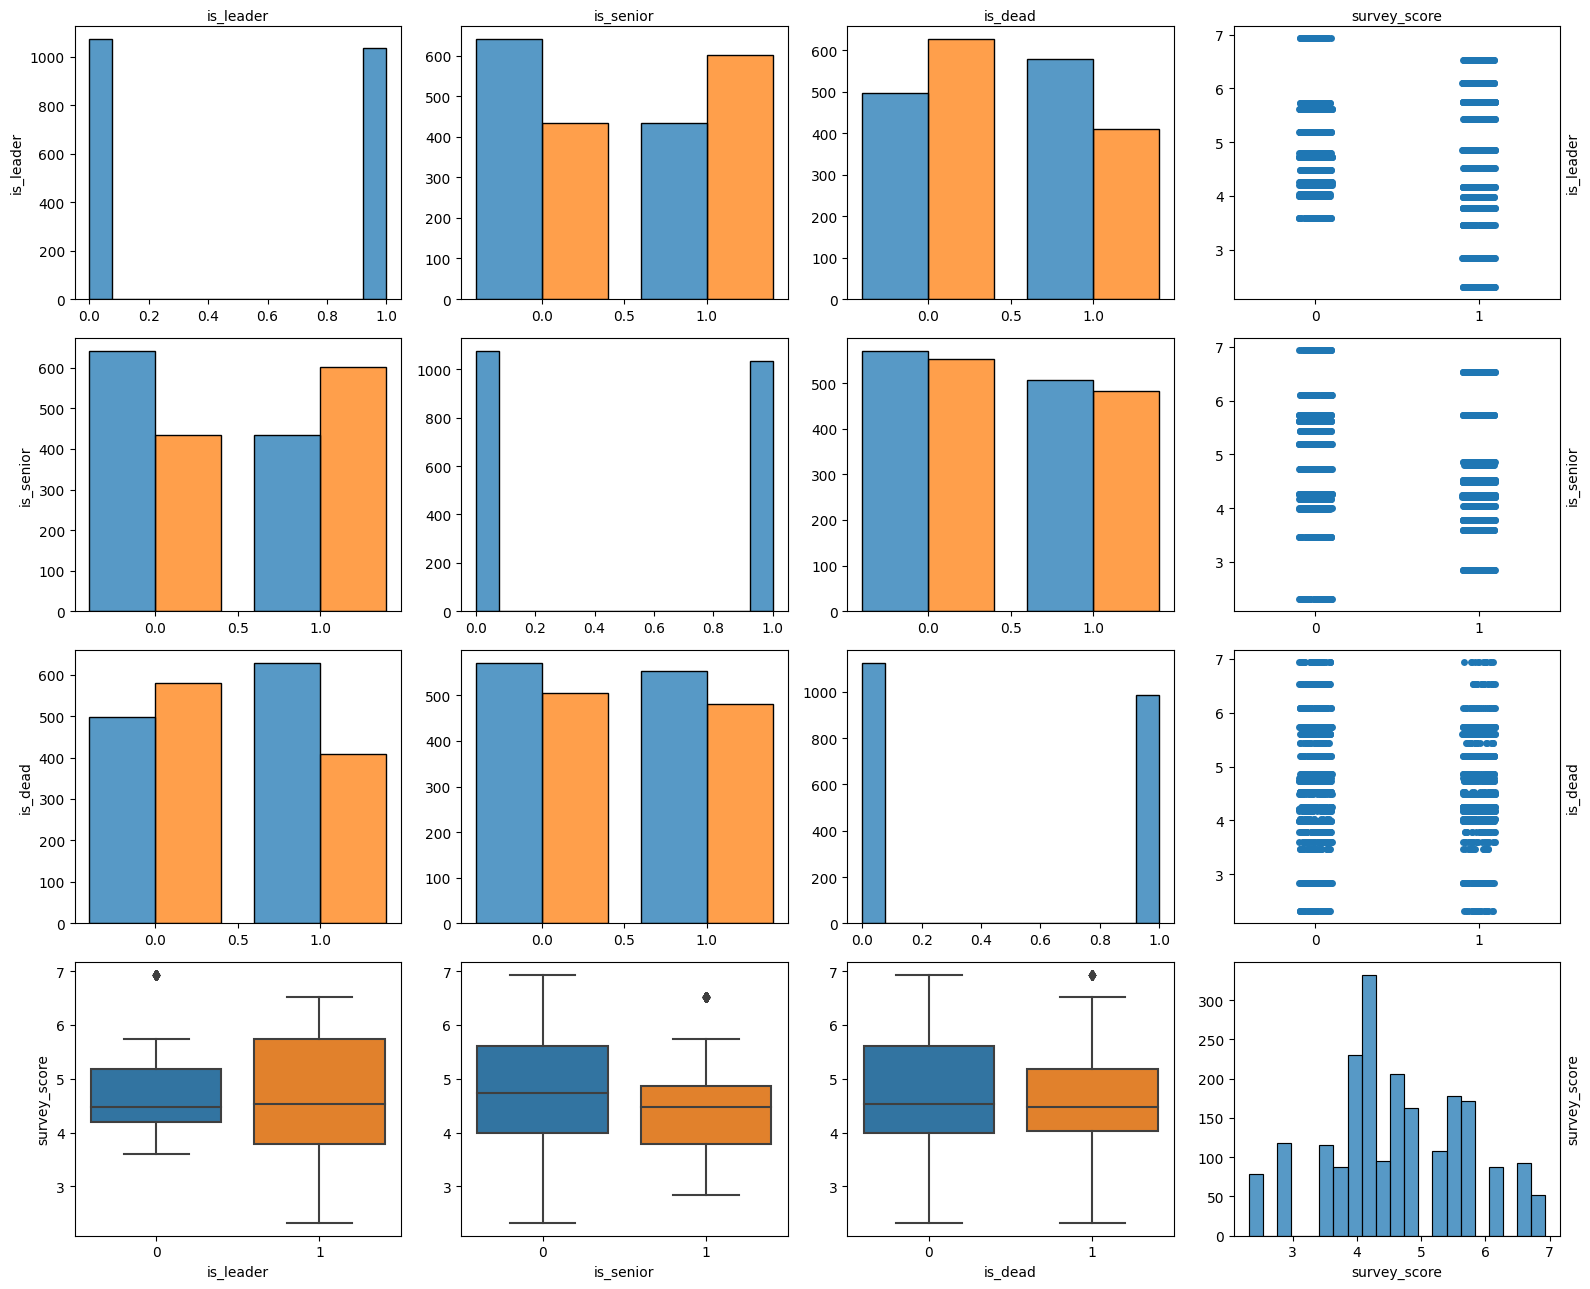

In [ ]:
my_ggpairs(data, ['is_leader', 'is_senior', 'is_dead', 'survey_score'])

Patients of leader physicians have lower death rate, so let's take is_leader feature.

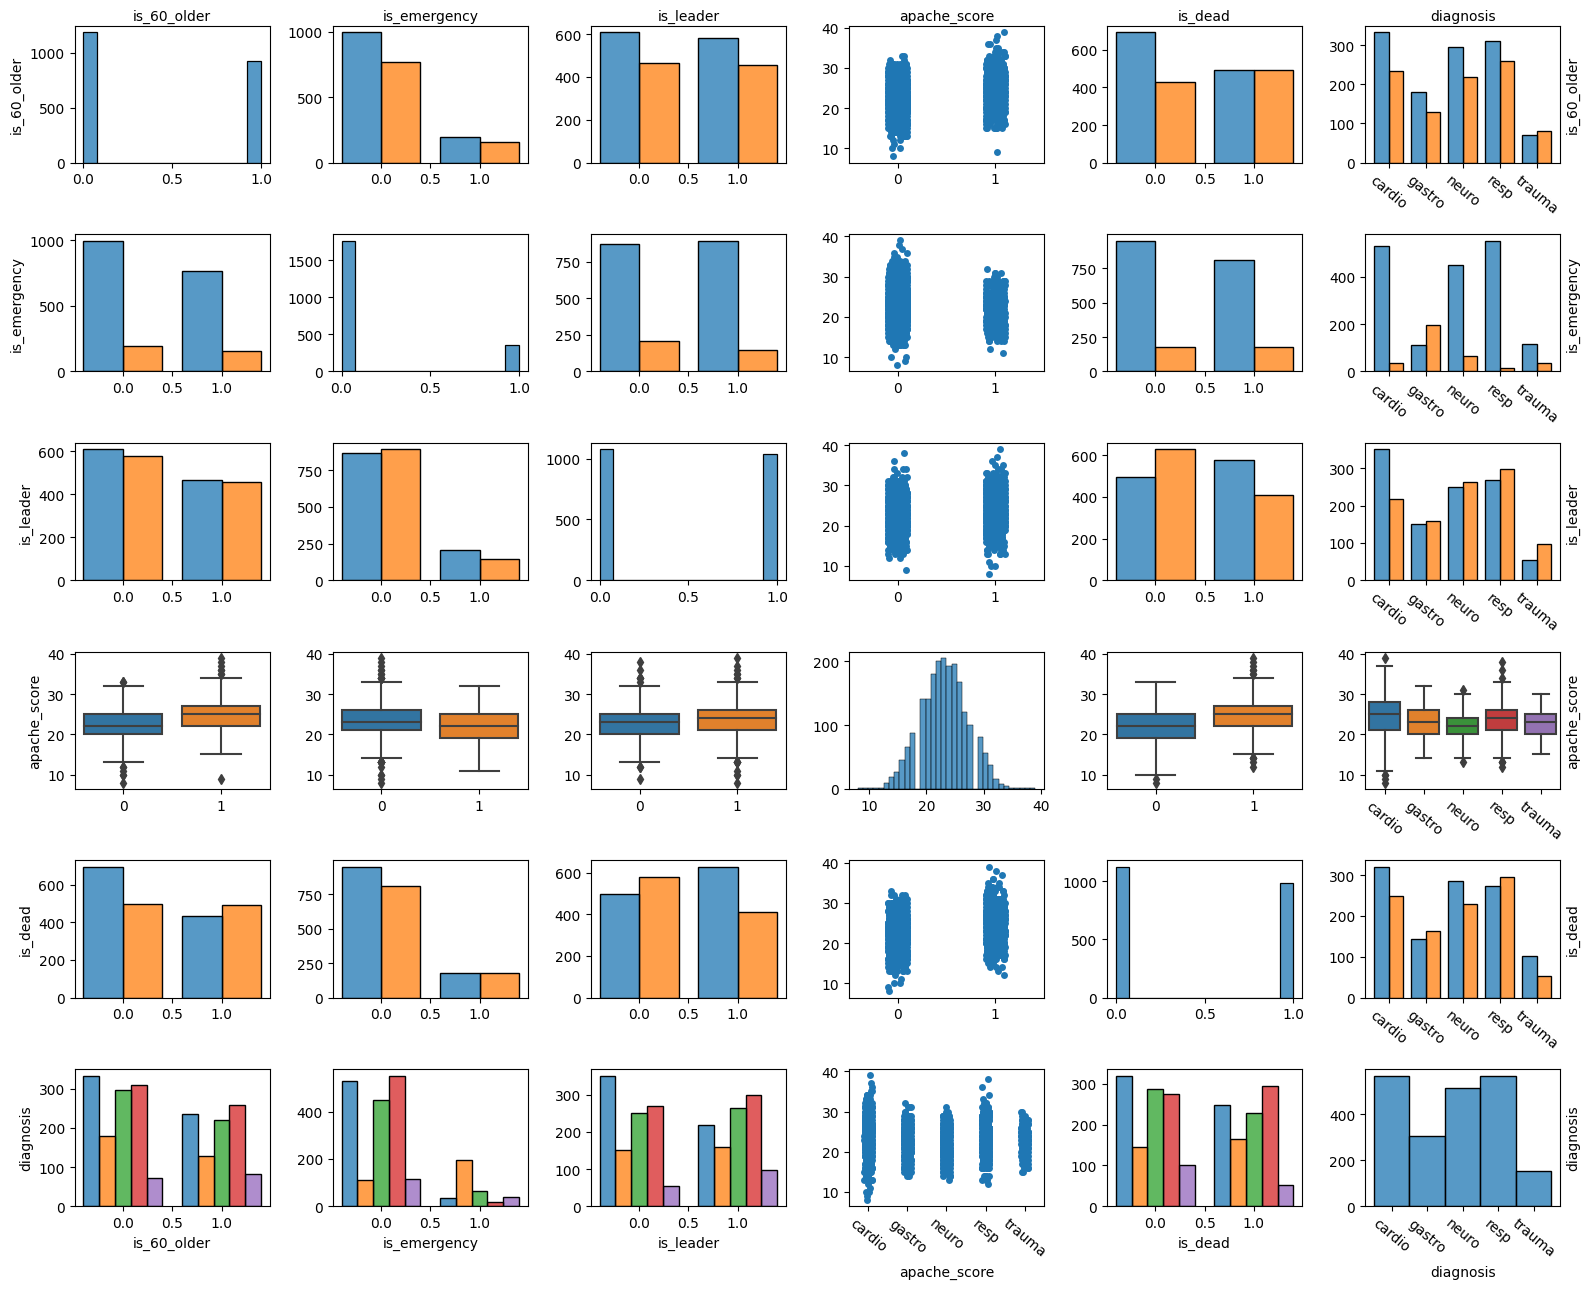

In [ ]:
# new_mix
my_ggpairs(data, [
            'is_60_older', 
            'is_emergency', 
            'is_leader', 
            'apache_score', 
            'is_dead', 
            'diagnosis', 
            ], ss_size=100)


Looking at is_leader column:

* only notable difference in distribution (for leader/non leader) is for diagnosis and is_dead pairplots
* we already knew that death rate is lower for leader physicians
* leaders have less cardio patients and more trauma patients. Since cardio and trauma patients have different death rate on average, let's see if leaders' patients lower death rate is explained by this fact

Let's find more relationships between features, this time between triples

I will do 2 separate plots: 

* first is a followup of previous; is_leader, diagnosis, death rate
* second will be about triple of diagnosis, emergency, death rate

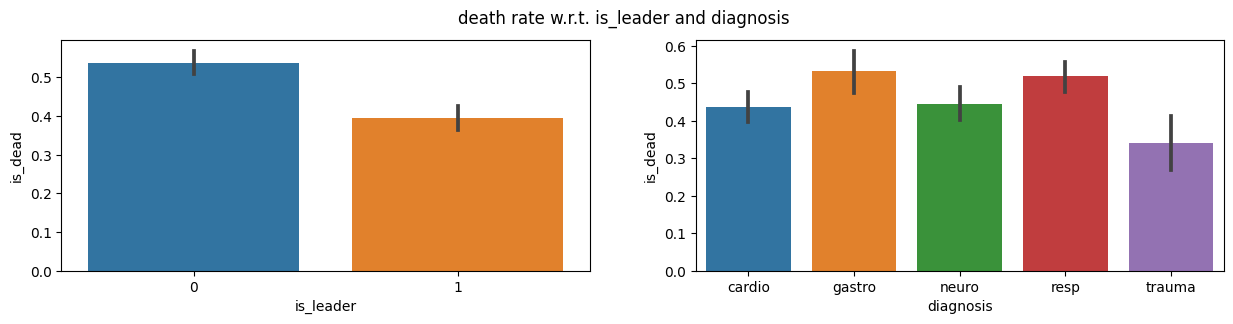

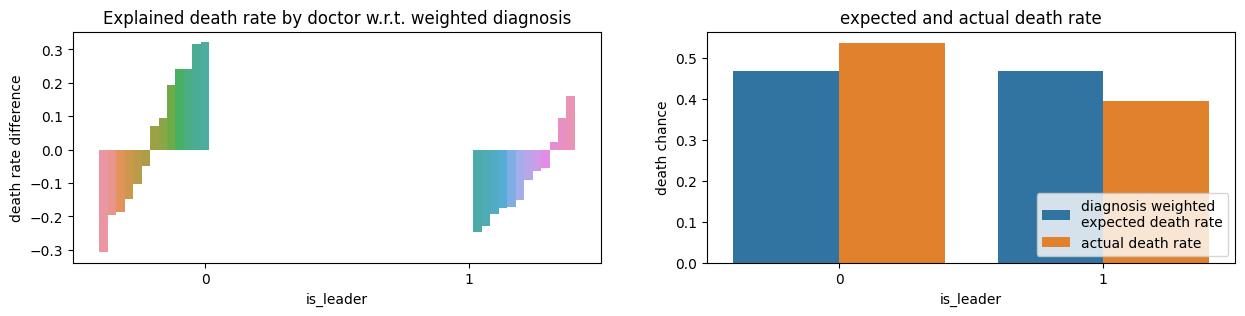

In [ ]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=.4, wspace=.2)
ax = fig.add_subplot(1, 2, 1)
sns.barplot(data=data, x='is_leader', y='is_dead', ax=ax)
ax = fig.add_subplot(1, 2, 2)
sns.barplot(data=data, x='diagnosis', y='is_dead', ax=ax)
fig.suptitle('death rate w.r.t. is_leader and diagnosis')
plt.show()

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=.4, wspace=.2)
ax = fig.add_subplot(1, 2, 1)
diagnosis_death_chance = data.groupby('diagnosis')['is_dead'].mean()
s = data.loc[:, ['diagnosis', 'is_dead', 'is_leader', 'DocID']]
s['diagnosis'] = s['diagnosis'].apply(lambda x : diagnosis_death_chance[x]).astype(float)
s = s.groupby('DocID').mean()
s['dif'] = s['is_dead'] - s['diagnosis']
s = s.reset_index()
s = s.sort_values(by=['is_leader', 'dif'])
sns.barplot(x=s['is_leader'].astype(int).astype('category'), y=s['dif'], hue=s['DocID'], width=0.8, ax=ax)
ax.set_xlabel('is_leader')
ax.set_ylabel('death rate difference')
ax.set_title('Explained death rate by doctor w.r.t. weighted diagnosis')
ax.legend([],[], frameon=False)

ax=fig.add_subplot(1, 2, 2)
diagnosis_death_chance = data.groupby('diagnosis')['is_dead'].mean()
s = data.loc[:, ['diagnosis', 'is_dead', 'is_leader']]
s['diagnosis'] = s['diagnosis'].apply(lambda x : diagnosis_death_chance[x]).astype(float)
s = s.groupby('is_leader').mean()
s = s.rename(columns={'is_dead': 'actual death rate', 'diagnosis': 'diagnosis weighted \nexpected death rate'})
s = s.reset_index().melt('is_leader')
sns.barplot(data=s, x='is_leader', y='value', hue='variable', ax=ax)
ax.set_ylabel('death chance')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc='lower right')
ax.set_title('expected and actual death rate')
plt.show()

Bottom left plot shows for each doctor (grouped into leaders/non leaders), difference between death rate of his/her patients and expected death rate weighted by diagnosis average death rates. Negative value means that physician has lower death rate of patients on average, taking into account diagnosis distribution.

Bottom right plot shows expected and actual death rates, grouped by is_leader variable.

From plots above it is evident that lower death rate of patients of leader physicians is not explainable by shift in diagnosis distribution. As usual in statistics, there still may be some other hidden factor, but for now we can propose that leader physicians indeed are better at saving patients.

Now let's examine triple of emergency, diagnosis, death rate

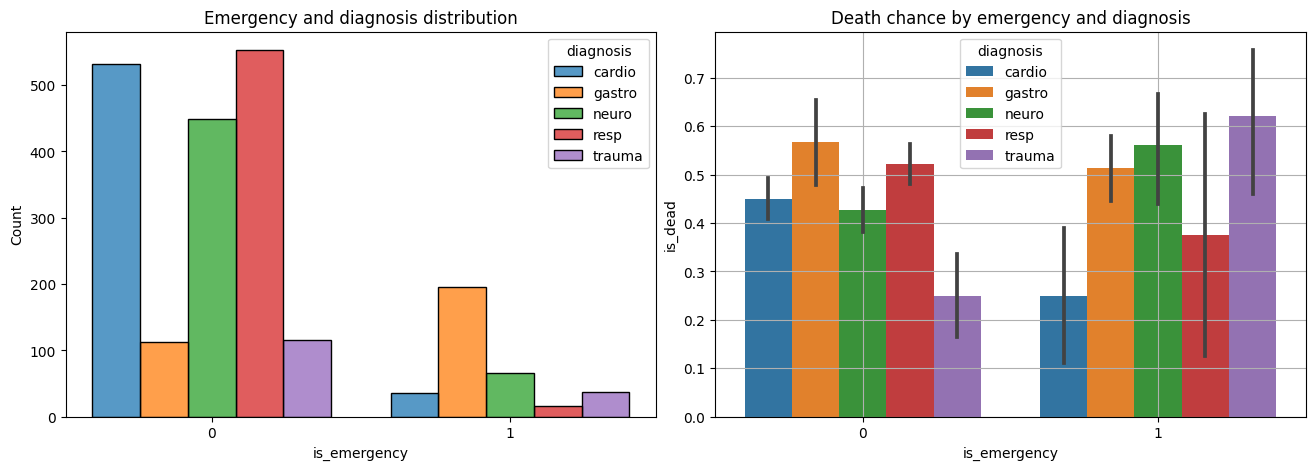

In [ ]:
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace=.4, wspace=.1)
ax = fig.add_subplot(1, 2, 1)
sns.histplot(x=data["is_emergency"].astype(str), hue=data["diagnosis"], common_norm=True, multiple='dodge', shrink=0.8, ax=ax)
ax.set_title('Emergency and diagnosis distribution')
ax = fig.add_subplot(1, 2, 2)
sns.barplot(data=data, x="is_emergency", y="is_dead", hue="diagnosis", ax=ax)
ax.grid()
ax.set_title('Death chance by emergency and diagnosis')
fig.show()

On the left, we can once again see that emergency patients have very different distribution from non emergency. In particular, gastro diagnosis dominate among emergency patients, followed by neuro.

Looking at right graph, assume that patient has trauma. Then, death chance increases from 25% to 62%, which is huge. On the other hand, a counterintuitive result is that cardio/gastro/respiratory patients have lower chance of death in case of emergency. 

There may be a bunch of statistical/non statistical reasons to that, I can name a couple:

* it may be the case that severity is assessed incorrectly. Therefore, if patient is not marked as emergent at the beginning, but should have been, then death chance increases
* there may be some dark data bias/influence, that we can't see
* there is some specific illness, that is not considered as emergency, but has higher death rate on average
* both cardio and respiratory have high variance in emergency case (black vertical line is 95% confidence interval), due to lack of enough data points

**Q4** Build a classification tree of one of the six variables from the last part as a function of the other five, and any other explanatory variables you think are necessary. Show code, explain reasoning, and show the tree as a simple (ugly) plot. Show the confusion matrix. Give two example predictions and follow them down the tree.

In python, there is no decent library that supports categorical variables for decision trees: you must one hot encode or order your categories, which I don't want to do (because interpretation hurts). Instead, I will substitute diagnosis with length of stay feature.

Instead of cross validation, I'm using holdout dataset of size 10% of original. I've done some hyperparameter tuning behind the scenes, but even with almost no constraints, my tree didn't overfit much, which is very rare.

My final constraints are: 
* split node only if currently there is at least 5% of dataset
* prune tree afterwards with ccp_alpha=0.001 (I don't know what this threshold exactly means)

I'm building classification tree of `is_dead` by
* is_60_older
* is_emergency
* is_leader (about physician)
* length_of_stay
* apache_score

In [ ]:
# Decision Tree Classifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

X = data[['is_60_older', 'is_emergency', 'is_leader', 'length_of_stay', 'apache_score']]
y = data['is_dead']

clf = tree.DecisionTreeClassifier(min_samples_split=0.05, ccp_alpha=0.001)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=223)
clf = clf.fit(X_train, y_train)

def get_values(y, X):
  roc_auc = roc_auc_score(y, list(zip(*clf.predict_proba(X)))[1])
  f1 = f1_score(y, clf.predict(X))
  acc = accuracy_score(y, clf.predict(X))
  return np.array([roc_auc, f1, acc])

metrics_df = pd.DataFrame(np.array([get_values(y_train, X_train), get_values(y_test, X_test)]), columns=['roc_auc', 'f1', 'accuracy'], index=['train', 'test'])
display(metrics_df)

print('\n\n')
def show_confusion_matrix(y, X):
  conf = confusion_matrix(y, clf.predict(X))
  conf = conf / conf.sum().sum()
  display(pd.concat([pd.concat([pd.DataFrame(conf)], keys=['y_true'])], keys=['y_pred'], axis=1))

print('Train dataset confusion matrix')
show_confusion_matrix(y_train, X_train)
print('\n')
print('Test dataset confusion matrix')
show_confusion_matrix(y_test, X_test)

,roc_auc,f1,accuracy
train,0.726586,0.620283,0.661231
test,0.740699,0.634409,0.679245





Train dataset confusion matrix


y_pred          
                 0         1
y_true 0  0.384534  0.146765
       1  0.192004  0.276696



Test dataset confusion matrix


y_pred          
                 0         1
y_true 0  0.400943  0.141509
       1  0.179245  0.278302

confusion matrices for train and test datasets are present above, as well as auc_roc, f1 scores, and accuracy score. There is not much to comment on.

Its worth mentioning that classes are almost balanced, so accuracy of 67% is definitely not some random noise. This was, of course, expected given patterns that we found in ggpairs plot.

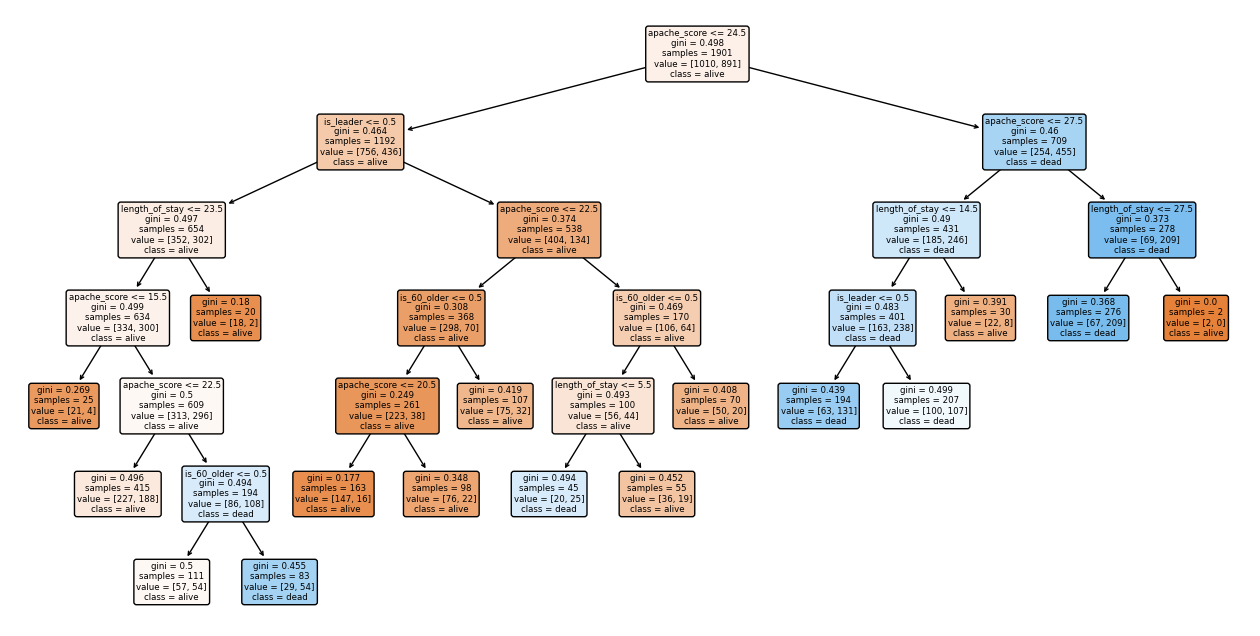

In [ ]:
plt.figure(figsize=(16,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=['alive', 'dead'], filled=True, rounded=True)
plt.show()

Let's make 2 predictions (I don't know what for, but ok)

In [ ]:
X_mock = X_test.iloc[:2, :]
y_pred = clf.predict(X_mock)
y_true = y_test.iloc[:2]
X_mock['y_true'] = y_true
X_mock['y_pred'] = y_pred
display(X_mock)


<ipython-input-33-1a58347f1227>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mock['y_true'] = y_true
<ipython-input-33-1a58347f1227>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mock['y_pred'] = y_pred


,is_60_older,is_emergency,is_leader,length_of_stay,apache_score,y_true,y_pred
290,0,0,1,25,22,0,0
400,0,0,0,6,19,0,0


Above are 2 random examples from test dataset. Both patients survived, and were predicted to survive.

* first example follows path [L (apache <= 24.5), R (is_leader), L (apache <= 22.5)], in this subtree all nodes return alive, so we stop
* second example follows path [L (apache <= 24.5), L (not is_leader), L (length of stay <= 23.5), R (apache > 15.5), L (apache = 22.5)], we reach leaf node

I can make a lot of comments examining each branch, but let's just make a few observations.

* looking at [L, R] path, apache_score <= 24 and leader physician gives 75% survival chance
* if in addition, patient is younger than 60 years old, survival chance increase to 81%
* we already knew patterns above from ggpairs plot (lower apache score, leader physician, young age each independently lead to higher survival rate)

As a summary, I would say that decision tree in this specific example may lead to some conclusions (how pair/triple of features predict survival chance), but these conclusions must be verified by plotting (or stat. test, but plotting is still useful). And in that case, we could just start by plotting, skipping intermediate step of building decision tree (if our job is to find patterns).

In [ ]:
print('feature importances:')
print(pd.Series(clf.feature_importances_, index=X.columns))

feature importances:
is_60_older       0.053100
is_emergency      0.000000
is_leader         0.208187
length_of_stay    0.103835
apache_score      0.634877
dtype: float64


Feature importance shows that emergency status was considered useless by this model. From ggpairs plot we knew, that emergency by itself doesn't help in explaining death rate. Perhaps, it may help if we combine it with other feature (like diagnosis). Unfortunately, I can't test that with this model (because of python).

**Q6** Build another model using one of the continuous variables from your six most important.

Let's build logistic regression to predict survival of patient.

We will use:

* patient features
  * is_60_older
  * is_emergency
  * comorbidity_index (integer from 1 to 3)
  * apache_score
  * initial_sofa_score
  * one hot encoded diagnosis
  * since we explored relation of is_emergency and diagnosis w.r.t. survival rate, we include product of is_emergency and ohe diagnosis
* physician features
  * is_leader
  * is_senior
  * survey_score
  * resident_ranking (integer from 1 to 3)
  * 360 survey encoded as 5 PCA dimensions


In [ ]:
data.columns

Index(['DocID', 'PtID', 'is_60_older', 'is_emergency', 'icu_department',
       'comorbidity_index', 'apache_score', 'initial_sofa_score',
       'is_male_patient', 'is_dead', 'length_of_stay', 'diagnosis',
       'sofa_list', 'final_sofa_score', 'mean_sofa_score', 'max_sofa_score',
       'variance_sofa_score', '48h_change_sofa_score', 'is_multiple_isu',
       'is_leader', 'is_senior', 'survey_score', 'resident_ranking',
       'is_male_doc', 'background_domain', 'is_50_older', 'university_degree',
       '360_0', '360_1', '360_2', '360_3', '360_4'],
      dtype='object')

In [ ]:
columns = ['is_60_older', 'is_emergency', 'comorbidity_index', 'apache_score', 'initial_sofa_score', 'is_leader', 'is_senior', 'survey_score', 'resident_ranking']
columns.extend([f'360_{j}' for j in range(5)])
X = data[columns]
y = data['is_dead']
X = pd.concat([X, 
          pd.get_dummies(X_patients['diagnosis']).multiply(X['is_emergency'], axis="index").add_prefix('emrg_'), 
          pd.get_dummies(X_patients['diagnosis']).add_prefix('is_')], 
          axis=1)
X

,is_60_older,is_emergency,comorbidity_index,apache_score,initial_sofa_score,is_leader,is_senior,survey_score,resident_ranking,360_0,...,emrg_cardio,emrg_gastro,emrg_neuro,emrg_resp,emrg_trauma,is_cardio,is_gastro,is_neuro,is_resp,is_trauma
0,0,0,1,27,11,0,1,4.033301,2,0.011492,...,0,0,0,0,0,1,0,0,0,0
1,0,0,3,22,5,0,1,4.033301,2,0.011492,...,0,0,0,0,0,1,0,0,0,0
2,1,0,3,22,5,0,1,4.033301,2,0.011492,...,0,0,0,0,0,1,0,0,0,0
3,0,0,3,21,6,0,1,4.033301,2,0.011492,...,0,0,0,0,0,1,0,0,0,0
4,1,0,2,24,6,0,1,4.033301,2,0.011492,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,1,1,1,19,8,0,0,6.936099,2,-0.303395,...,0,0,0,0,1,0,0,0,0,1
2109,0,1,1,17,8,0,0,6.936099,2,-0.303395,...,0,0,0,0,1,0,0,0,0,1
2110,0,1,2,23,9,0,0,6.936099,2,-0.303395,...,0,1,0,0,0,0,1,0,0,0
2111,0,1,3,25,12,0,0,6.936099,2,-0.303395,...,0,1,0,0,0,0,1,0,0,0


We will use best subsets (approximate calculations for speed).

In [ ]:
# !pip install abess==0.4.5

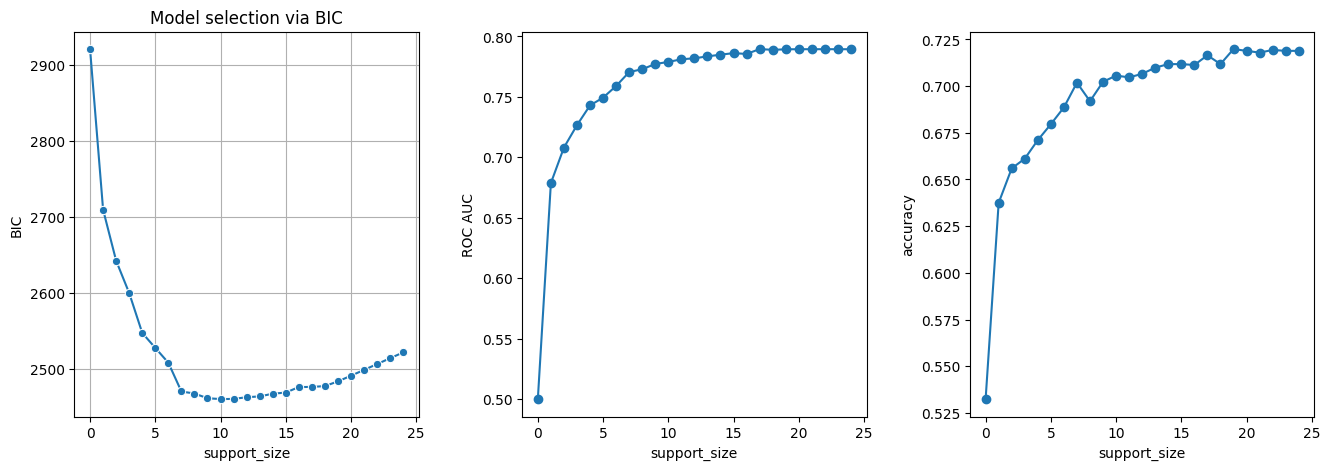

In [ ]:
# as usual, I use analogous python package (also available in R): https://github.com/abess-team/abess
import abess

max_features = len(X.columns)
coef = np.zeros((max_features + 1, max_features))
ic = np.zeros(max_features + 1)
roc_auc = np.zeros(max_features + 1)
accuracy = np.zeros(max_features + 1)
models = []
for s in range(max_features + 1):
  model = abess.LogisticRegression(support_size=s, ic_type='bic')
  model.fit(X.to_numpy(), y.to_numpy())
  models.append(model)
  coef[s, :] = model.coef_
  ic[s] = model.ic_
  roc_auc[s] = roc_auc_score(y, model.predict_proba(X.to_numpy())[:, 1])
  accuracy[s] = accuracy_score(y, model.predict(X.to_numpy()))

def draw_plots(start, end):
  fig = plt.figure(figsize=(16, 5))
  fig.subplots_adjust(hspace=.4, wspace=.3)
  ax = fig.add_subplot(1, 3, 1)
  sns.lineplot(x=range(start, end), y=ic[start:end], marker='o', ax=ax)
  ax.set_xlabel('support_size')
  ax.set_ylabel('BIC')
  ax.set_title('Model selection via BIC')
  ax.grid()
  
  ax = fig.add_subplot(1, 3, 2)
  ax.plot(range(start, end), roc_auc[start:end], 'o-')
  ax.set_xlabel('support_size')
  ax.set_ylabel('ROC AUC')

  ax = fig.add_subplot(1, 3, 3)
  ax.plot(range(start, end), accuracy[start:end], 'o-')
  ax.set_xlabel('support_size')
  ax.set_ylabel('accuracy')
  plt.show()

draw_plots(0, max_features + 1)

Let's zoom in to [7..] support size segment

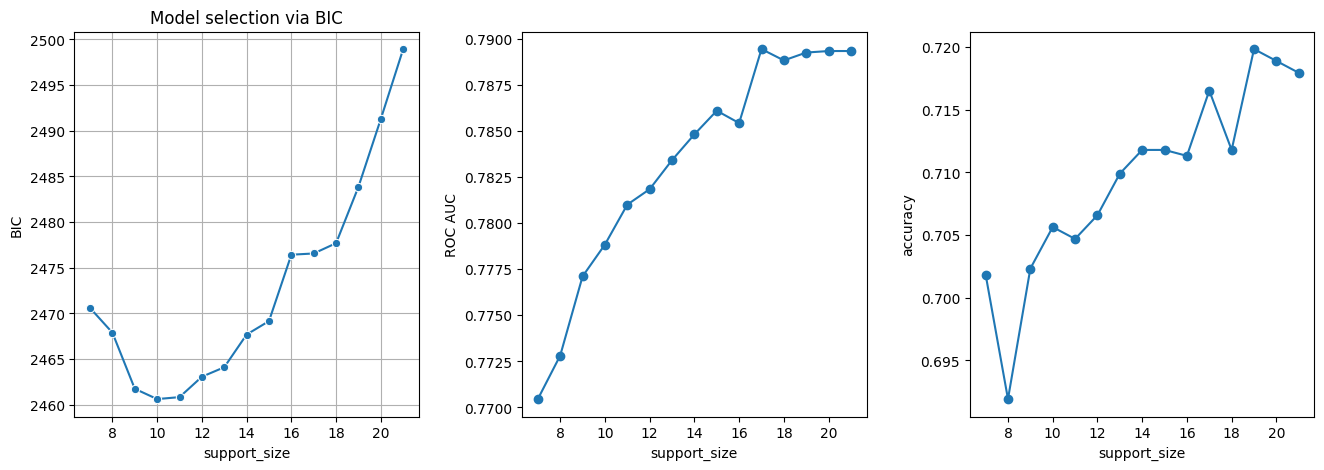

In [ ]:
draw_plots(7, 22)

support size of 10 seems reasonable (it has lowest BIC score).

In [ ]:
def print_metrics(X, y, md):
  roc_auc = roc_auc_score(y, md.predict_proba(X)[:, 1])
  f1 = f1_score(y, md.predict(X))
  acc = accuracy_score(y, md.predict(X))
  print(f'ROC AUC score: {roc_auc}')
  print(f'f1 score: {f1}')
  print(f'accuracy score: {acc}')

print('Logistic Regression with 10 features:')
print_metrics(X, y, models[10])

print('\n\nDecision Tree metrics:')
display(metrics_df)

Logistic Regression with 10 features:
ROC AUC score: 0.7788398560503824
f1 score: 0.6839430894308943
accuracy score: 0.705631803123521


Decision Tree:


,roc_auc,f1,accuracy
train,0.726586,0.620283,0.661231
test,0.740699,0.634409,0.679245


Our logistic regression beats previous decision tree. It was expected, considering increase in number of features and features selection by best subsets.

It's worth noting that I tried logistic regression with same features as for decision tree offscreen, and it was worse than decision tree.

Let's print which features entered and exited best subsets model for support sizes from 1 to 11

In [ ]:
prev = set([])
for i in range(1, 12):
  cur = set(X.columns[coef[i] != 0])
  print('step', i)
  print('added', cur.difference(prev))
  dif = prev.difference(cur)
  if dif:
    print('removed', dif)
  prev = cur

step 1
added {'apache_score'}
step 2
added {'is_leader'}
step 3
added {'360_2'}
step 4
added {'is_cardio'}
step 5
added {'360_1'}
step 6
added {'initial_sofa_score'}
step 7
added {'resident_ranking'}
step 8
added {'is_senior'}
step 9
added {'360_4'}
step 10
added {'emrg_trauma'}
step 11
added {'emrg_neuro'}


It seems like survey 360 has relatively good prediction strength, since 3 out of 5 PCA dimensions were added. 

Note, that emrg_trauma (1 if and only if patient is emergency and trauma diagnosis) was also added. In hindsight, from previous graphs we know that trauma is diagnosis for which survival chance differs the most when comparing emergency/non emergency patients.

In [ ]:
X_selected = X[X.columns[coef[10] != 0]]
X_selected

,apache_score,initial_sofa_score,is_leader,is_senior,resident_ranking,360_1,360_2,360_4,emrg_trauma,is_cardio
0,27,11,0,1,2,0.136734,-0.371399,-0.050465,0,1
1,22,5,0,1,2,0.136734,-0.371399,-0.050465,0,1
2,22,5,0,1,2,0.136734,-0.371399,-0.050465,0,1
3,21,6,0,1,2,0.136734,-0.371399,-0.050465,0,1
4,24,6,0,1,2,0.136734,-0.371399,-0.050465,0,1
...,...,...,...,...,...,...,...,...,...,...
2108,19,8,0,0,2,-0.754143,0.635765,-0.272102,1,0
2109,17,8,0,0,2,-0.754143,0.635765,-0.272102,1,0
2110,23,9,0,0,2,-0.754143,0.635765,-0.272102,0,0
2111,25,12,0,0,2,-0.754143,0.635765,-0.272102,0,0


<Axes: >

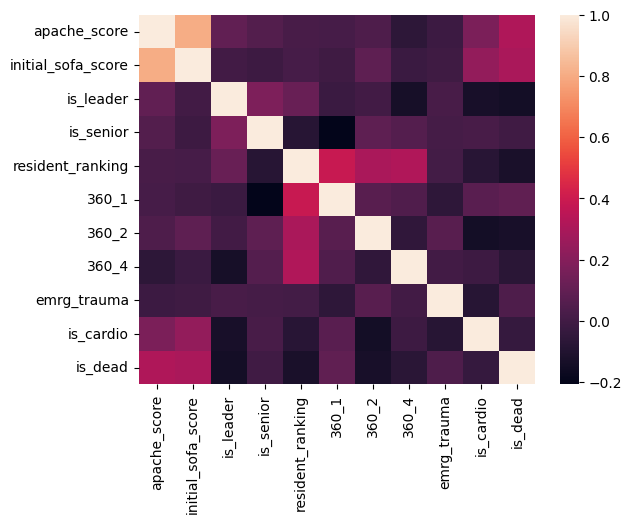

In [ ]:
sns.heatmap(X_selected.assign(is_dead = y).corr())

Our features are mostly uncorrelated, with few exceptions.

We already knew about apache and sofa scores correlation. Suprisingly, resident ranking and survey 360 PCA dimensions have positive correlation as well.

In [ ]:
import statsmodels.api as sm

def print_metrics(X, y, md):
  y_prob = md.predict(X)
  y_pred = (y_prob >= 0.5)
  roc_auc = roc_auc_score(y, y_prob)
  f1 = f1_score(y, y_pred)
  acc = accuracy_score(y, y_pred)
  print(f'ROC AUC score: {roc_auc}')
  print(f'f1 score: {f1}')
  print(f'accuracy score: {acc}')

model = sm.Logit(y, sm.add_constant(X_selected))
results = model.fit()
print_metrics(sm.add_constant(X_selected), y, results)
results.summary()

Optimization terminated successfully.
         Current function value: 0.564137
         Iterations 6
ROC AUC score: 0.7788398560503824
f1 score: 0.6839430894308943
accuracy score: 0.705631803123521


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_dead   No. Observations:                 2113
Model:                          Logit   Df Residuals:                     2102
Method:                           MLE   Df Model:                           10
Date:                Sat, 22 Apr 2023   Pseudo R-squ.:                  0.1836
Time:                        23:22:08   Log-Likelihood:                -1192.0
converged:                       True   LL-Null:                       -1460.2
Covariance Type:            nonrobust   LLR p-value:                7.617e-109
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.3575      0.406     -8.268      0.000      -4.153      -2.562
apache_score           0.1412      0.022      6.475      0.000       0.098       0.184
initial_sofa_score     0.1964      0.033      5.873      0.000       0.131       0.262
is_leader             -1.0707      0.113     -9.501      0.000      -1.292      -0.850
is_senior              0.4068      0.108      3.751      0.000       0.194       0.619
resident_ranking      -0.4643      0.101     -4.593      0.000      -0.662      -0.266
360_1                  1.4563      0.185      7.872      0.000       1.094       1.819
360_2                 -1.7766      0.216     -8.232      0.000      -2.200      -1.354
360_4                 -0.8778      0.234     -3.753      0.000      -1.336      -0.419
emrg_trauma            1.1689      0.403      2.897      0.004       0.378       1.960
is_cardio             -1.2273      0.130     -9.434      0.000      -1.482      -0.972
======================================================================================
"""

Z score tells us that all features are statistically important.



For interest, let's remove survey 360 from the model.

In [ ]:
X_crop = X_selected.drop(columns=['360_1', '360_2', '360_4'])
model = sm.Logit(y, sm.add_constant(X_crop))
results = model.fit()
print_metrics(sm.add_constant(X_crop), y, results)
results.summary()

Optimization terminated successfully.
         Current function value: 0.598500
         Iterations 6
ROC AUC score: 0.7379158794421952
f1 score: 0.6380558428128231
accuracy score: 0.6687174633222905


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_dead   No. Observations:                 2113
Model:                          Logit   Df Residuals:                     2105
Method:                           MLE   Df Model:                            7
Date:                Sat, 22 Apr 2023   Pseudo R-squ.:                  0.1339
Time:                        23:22:08   Log-Likelihood:                -1264.6
converged:                       True   LL-Null:                       -1460.2
Covariance Type:            nonrobust   LLR p-value:                 1.940e-80
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.9926      0.372     -8.046      0.000      -3.722      -2.264
apache_score           0.1580      0.021      7.518      0.000       0.117       0.199
initial_sofa_score     0.1176      0.031      3.780      0.000       0.057       0.179
is_leader             -0.8776      0.103     -8.497      0.000      -1.080      -0.675
is_senior              0.0534      0.099      0.541      0.589      -0.140       0.247
resident_ranking      -0.4979      0.081     -6.147      0.000      -0.657      -0.339
emrg_trauma            0.7035      0.372      1.890      0.059      -0.026       1.433
is_cardio             -0.8567      0.120     -7.125      0.000      -1.092      -0.621
======================================================================================
"""

Removing survey 360, we loose 

* 0.04 in pseudo R2
* 3% in accuracy
* 4% in ROC AUC
* 4% in F1 score

Given relative values, I would say this is significant. So answering our initial question, survey 360 indeed has useful information for predicting how good physician prevents death of patients.

**Q8** Discuss briefly any ethical concerns like residual disclosure that might arise from the use of your data set, possibly in combination with some additional data outside your dataset. (Optional)

At SSC page, it says:

> The data to be utilized in this case study challenge is ‘mock’ data that has been developed in consultation from ICU healthcare service professionals.

I don't know how exactly this data was constructed. My guess is that they took real data and added random noise to it.

This dataset definitely might have theoretical residual disclosure issue. I don't know how many ICU departments are there, and how many ICU physicians exist (in Alberta, which I guess is where it's from), but I would say with dataset of this size, it's impossible to identify someone. If our task was, given real physician, find him/her in the dataset that contained all ICU physicians, then sex, university degree, age, background domain and some other features would be useful. Adding more information, like city, may in theory make it possible to identify specific person.

I see another theoretical issue that may arise with this dataset, which is public opinion shift. If some publication based on such data becomes widely discussed, then it may affect how public views physicians/ICU department as a whole. It may negatively affect physicians that will fit some criteria (like not being lead physician, as we saw before). On the other hand, there are definitely very useful conclusions that can be made from this kind of dataset.

# Appendix

Survey 360 exploration


NOTE: this part is much less fun than stuff above.

In [ ]:
df_eval360.isna().sum()

Q1           23
Q2           44
Q3           47
Q4           23
Q5           57
Q6           17
Q7            0
Q8           22
Q9           62
Q10          13
Q11          18
Q12          21
Q13          66
Q14          18
Q15          27
Q16          14
Q17          24
Q18          87
Q19          25
Q20         524
Q21          37
Q22         100
Q23          26
DocID         0
position      0
dtype: int64

We have a bunch of NAs in evaluation survey

In dataset description, survey questions are categorized into groups:
* Medical Expert
* Advocacy
* Scientific knowledge
* Professionalism
* Communication
* Collaboration
* Management
* Overall Score

For ease of interpretability, I want to aggregate responses into these groups. I see two ways: calculate mean inside questions, then mean inside groups. The other is to get first PCA dimension inside each group. First approach is easier to interpret, while the second should result in greater explained variance. For now, I will use first approach.

In [ ]:
df_eval360.position.value_counts()

bedside        573
non-bedside    227
Name: position, dtype: int64

From datasets description: 
> A medical director, patient care manager, and unit manager are non-bedside participants.

I'm interested whether bedside and non-bedside responses differ. Let's calculate average response for each question and compare it between bedside and non-bedside respondents.

In [ ]:
bedside = df_eval360[df_eval360.position == 'bedside']
non_bedside = df_eval360[df_eval360.position == 'non-bedside']
bedside = bedside.groupby('DocID').mean()
non_bedside = non_bedside.groupby('DocID').mean()
(bedside - non_bedside).mean().sort_values()

<ipython-input-48-24b2a2676283>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bedside = bedside.groupby('DocID').mean()
<ipython-input-48-24b2a2676283>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  non_bedside = non_bedside.groupby('DocID').mean()


Q15   -0.165145
Q21   -0.121003
Q12   -0.114085
Q13   -0.106026
Q8    -0.091288
Q7    -0.071638
Q22   -0.044391
Q6    -0.030361
Q14   -0.017423
Q1     0.001271
Q16    0.009556
Q4     0.011099
Q11    0.026350
Q9     0.056704
Q10    0.065376
Q18    0.072116
Q20    0.082926
Q17    0.086746
Q2     0.087950
Q5     0.140101
Q19    0.160651
Q23    0.164104
Q3     0.172410
dtype: float64

Looking at specific questions at both ends of the spectrum (Q15, Q21, Q3, Q23), I don't see any meaningful pattern. For example, it is not true that collaboration questions or management questions all are at minimum/maximum values.

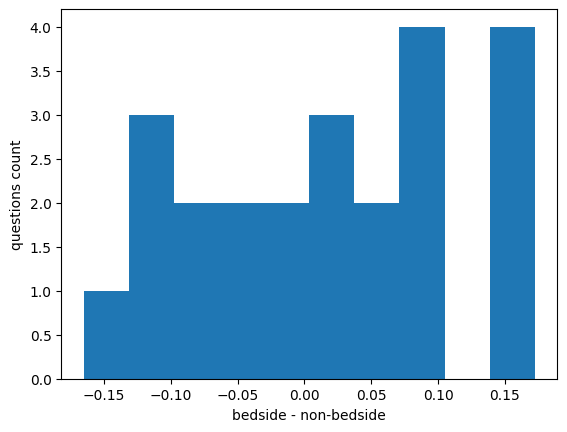

In [ ]:
plt.hist((bedside - non_bedside).mean())
plt.xlabel('bedside - non-bedside')
plt.ylabel('questions count')
plt.show()

<ipython-input-50-57173a74ecfd>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks)


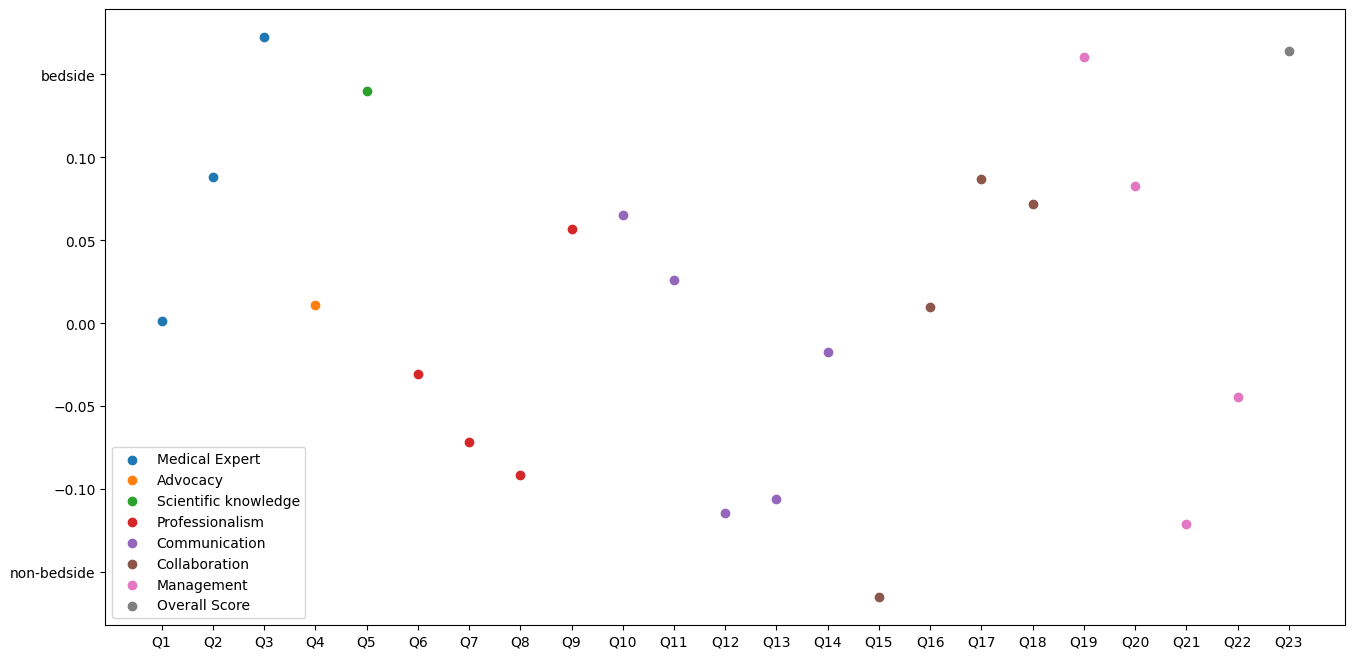

In [ ]:
df = (bedside - non_bedside).mean().sort_values()

fig, ax = plt.subplots()
fig.set_size_inches((16, 8))
# fig, ax = plt.figure(figsize=(16, 8))
# plt.xticks(ticks=range(len(df.index)), label=df.index)
# plt.plot(df, color='w')

def make_plot(l, r, name):
  z = df.loc[['Q' + str(x) for x in range(l, r)]]
  ax.scatter(z.index, z.values, label=name)
names = ['Medical Expert', 'Advocacy', 'Scientific knowledge', 'Professionalism', 'Communication', 'Collaboration', 'Management', 'Overall Score']
numbers = [1, 4, 5, 6, 10, 15, 19, 23, 24]
for i in range(len(names)):
  make_plot(numbers[i], numbers[i + 1], names[i])
ticks = list(map(lambda x : x.get_text(), plt.yticks()[1]))
ticks[1] = 'non-bedside'
ticks[-2] = 'bedside'
# display(ticks)
ax.set_yticklabels(ticks)
# ax.set_ylabel('bedside - non_bedside')
ax.legend()
fig.show()


x axis corresponds to questions from survey, y axis corresponds to difference between bedside and non-bedside average responds. At the top we have questions that are more positively answered by bedside respondents, and vice versa at the bottom.

I don't see any significant patterns in this plot, so I will assume that bedside and non-bedside responds are statistically indifferent (at least in terms of their mean).

<ipython-input-51-d88f10965fce>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_eval360.groupby('DocID').mean().mean()


[]

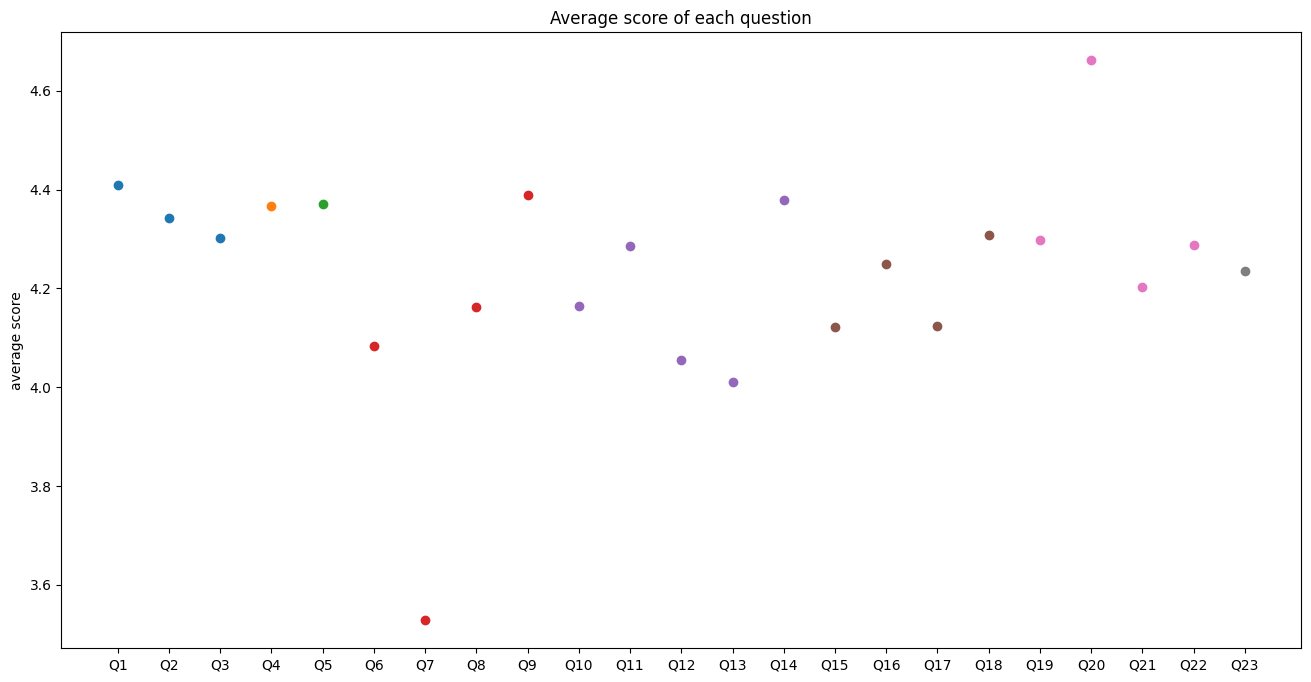

In [ ]:
df = df_eval360.groupby('DocID').mean().mean()
fig, ax = plt.subplots()
fig.set_size_inches((16, 8))
for i in range(len(names)):
  make_plot(numbers[i], numbers[i + 1], names[i])
ax.set_ylabel('average score')
ax.set_title('Average score of each question')
ax.plot()
# plt.scatter(df.index, df.values)

In [ ]:
len(df_eval360)

800

In [ ]:
df_eval360.isna().sum()

Q1           23
Q2           44
Q3           47
Q4           23
Q5           57
Q6           17
Q7            0
Q8           22
Q9           62
Q10          13
Q11          18
Q12          21
Q13          66
Q14          18
Q15          27
Q16          14
Q17          24
Q18          87
Q19          25
Q20         524
Q21          37
Q22         100
Q23          26
DocID         0
position      0
dtype: int64

In [ ]:
df_eval360.groupby('DocID').mean()[['Q7', 'Q20']]

<ipython-input-54-4973bdc28c42>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_eval360.groupby('DocID').mean()[['Q7', 'Q20']]


,Q7,Q20
DocID,,
doc-01,3.466667,4.777778
doc-02,3.440678,4.473684
doc-03,3.541667,4.416667
doc-04,3.437500,4.450000
doc-05,3.714286,4.600000
doc-06,3.857143,4.600000
doc-07,3.478261,4.666667
doc-08,3.433333,4.687500
doc-09,3.424242,4.666667


There is some weird pattern: lowest score is Q7 (Demonstrates honesty and integrity), higest score is Q20 (Effectively manages the team during acute resuscitation of critically ill patients). At the same time, Q7 is the only question with 0 NAs, and Q20 is the question with highest NA count (524 out of 800).

This is strange and may suggest that means are calculated incorrectly, but I double checked documentation and it should be correct. Looking at means by physician, there is nothing strange as well.

In [ ]:

names = ['Medical Expert', 'Advocacy', 'Scientific knowledge', 'Professionalism', 'Communication', 'Collaboration', 'Management', 'Overall Score']
numbers = [1, 4, 5, 6, 10, 15, 19, 23, 24]

df = df_eval360.groupby('DocID').mean()
df_full = df.reset_index().loc[:, ['DocID']].set_index('DocID')
for i in range(len(names)):
  z = df.loc[:, ['Q' + str(x) for x in range(numbers[i], numbers[i + 1])]]
  z = z.mean(axis=1)
  df_full[names[i]] = z
df_full

<ipython-input-55-318ac9510084>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_eval360.groupby('DocID').mean()


,Medical Expert,Advocacy,Scientific knowledge,Professionalism,Communication,Collaboration,Management,Overall Score
DocID,,,,,,,,
doc-01,4.324492,4.241379,4.080000,3.985632,4.192418,4.213362,4.402778,4.392857
doc-02,4.316727,4.258621,4.425926,3.981905,4.234780,4.200582,4.377680,4.206897
doc-03,4.371291,4.297872,4.476190,4.010195,4.200598,4.297569,4.303539,4.173913
doc-04,4.199466,4.333333,4.500000,3.897633,4.121494,4.225440,4.238244,4.239130
doc-05,4.465538,4.514286,4.147059,4.160708,4.161450,4.223136,4.382685,4.029412
doc-06,4.344737,4.333333,4.500000,4.096429,4.259048,4.321209,4.419444,4.157895
doc-07,4.246377,4.409091,4.090909,4.058418,4.149689,4.174784,4.251318,4.238095
doc-08,4.314815,4.620690,4.653846,4.128489,4.102963,4.202139,4.474749,4.400000
doc-09,4.406810,4.212121,4.580645,3.975802,4.236932,4.168415,4.441148,3.939394


Responds are aggregated as mean by question, then as mean by question group (which means that each question has equal weight, but each response has not). Let's see if groups are correlated.

,Medical Expert,Advocacy,Scientific knowledge,Professionalism,Communication,Collaboration,Management,Overall Score
Medical Expert,1.000000,0.156794,0.250966,0.092112,0.346504,0.481897,0.201021,0.041300
Advocacy,0.156794,1.000000,0.005170,-0.059788,-0.178946,0.127573,-0.125461,0.186070
Scientific knowledge,0.250966,0.005170,1.000000,-0.088428,0.006312,0.223322,0.280648,0.340684
Professionalism,0.092112,-0.059788,-0.088428,1.000000,-0.037825,-0.159871,0.447688,-0.181609
Communication,0.346504,-0.178946,0.006312,-0.037825,1.000000,0.070886,0.011274,-0.392418
Collaboration,0.481897,0.127573,0.223322,-0.159871,0.070886,1.000000,0.108399,0.108039
Management,0.201021,-0.125461,0.280648,0.447688,0.011274,0.108399,1.000000,-0.124121
Overall Score,0.041300,0.186070,0.340684,-0.181609,-0.392418,0.108039,-0.124121,1.000000


<Axes: >

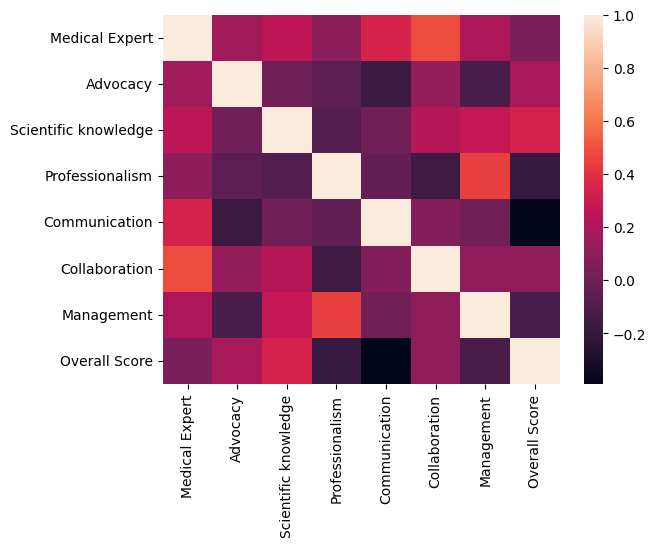

In [ ]:
display(df_full.corr())
sns.heatmap(df_full.corr())

Let's examine highest correlated pairs by absolute value.

* 0.48 Collaboration - Medical Expert
* 0.44 Management - Professionalism
* 0.34 Overall Score - Scientific knowledge (it may be interesting to examine the group that has highest correlation with Overall Score, since Overall Score normally should be the main metric)
* -0.39 Overall Score - Communication

<Axes: xlabel='DocID'>

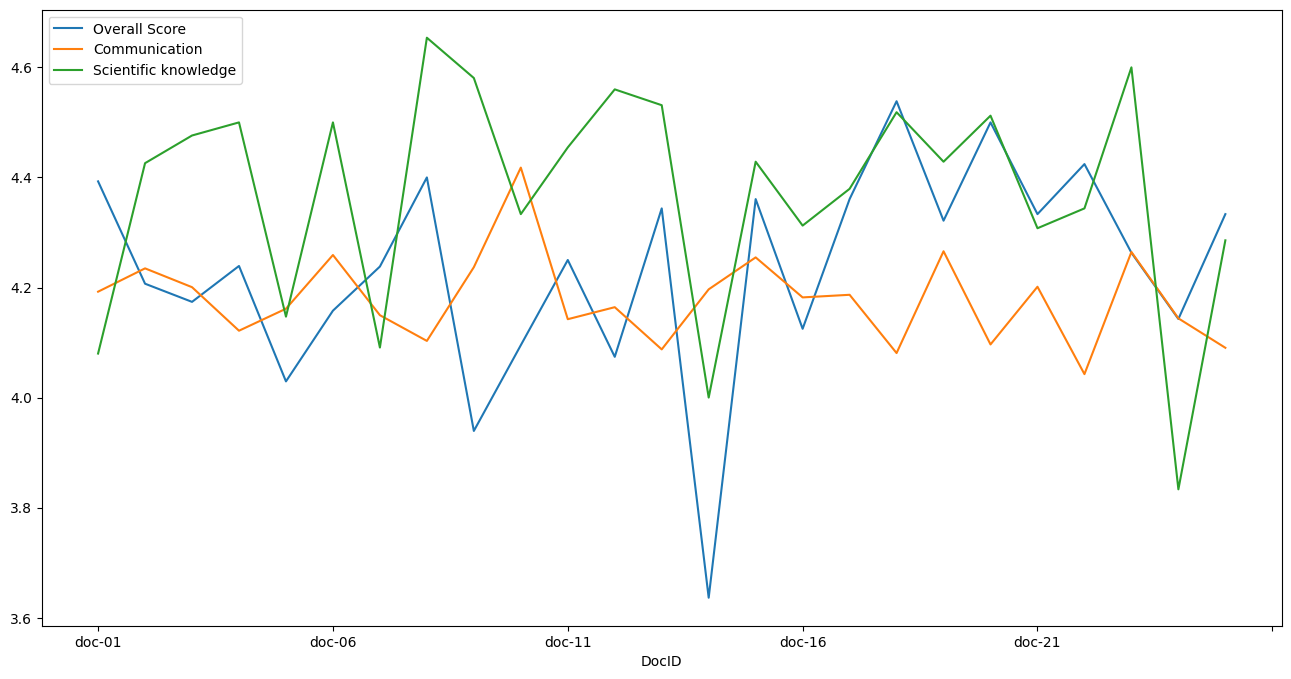

In [ ]:
df_full[['Overall Score', 'Communication', 'Scientific knowledge']].plot(figsize=(16,8))


Looking at descriptions of questions, I can't make any reasonable conclusions. Based on questions themselves, I can't really distinguish between Management/Collaboration/Communication, so I will treat them simply as features.

Now let's try to predict Overall Score based on grouped responses.

In [ ]:
Y = df_full['Overall Score']
X = sm.add_constant(df_full.drop(columns=['Overall Score']))
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1.303
Date:                Sat, 22 Apr 2023   Prob (F-statistic):              0.307
Time:                        23:22:11   Log-Likelihood:                 11.643
No. Observations:                  25   AIC:                            -7.287
Df Residuals:                      17   BIC:                             2.464
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.2870      4.079      2.032      0.058      -0.319      16.893
Medical Expert           0.3011      0.519      0.580      0.569      -0.794       1.396
Advocacy                 0.0843      0.328      0.257      0.800      -0.608       0.777
Scientific knowledge     0.3366      0.204      1.648      0.118      -0.094       0.768
Professionalism         -0.1387      0.367     -0.377      0.710      -0.914       0.636
Communication           -1.0404      0.523     -1.989      0.063      -2.144       0.063
Collaboration           -0.0339      0.679     -0.050      0.961      -1.466       1.398
Management              -0.4930      0.585     -0.842      0.411      -1.728       0.742
==============================================================================
Omnibus:                        2.397   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.201
Skew:                          -0.503   Prob(JB):                        0.549
Kurtosis:                       3.376   Cond. No.                     1.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

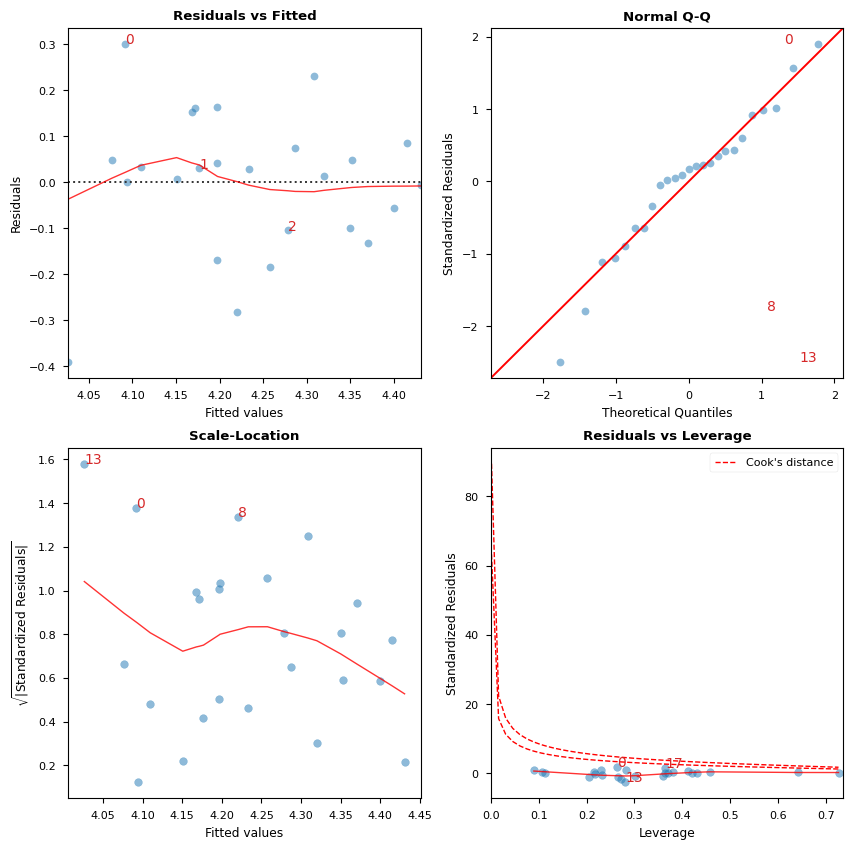

               Features  VIF Factor
2              Advocacy        1.14
3  Scientific knowledge        1.23
5         Communication        1.26
6         Collaboration        1.43
4       Professionalism        1.44
7            Management        1.50
1        Medical Expert        1.72
0                 const    12263.17


(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>,
         <Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>],
        [<Axes: title={'center': 'Scale-Location'}, xlabel='Fitted values', ylabel='$\\sqrt{|\\mathrm{Standardized\\ Residuals}|}$'>,
         <Axes: title={'center': 'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>]],
       dtype=object))

In [ ]:
Linear_Reg_Diagnostic(results)()

Our R2 score is 0.349, which is expected given correlation that we found. Our features are correlated as well, and OLS model hints that: 
> The condition number is large, 1.27e+03. This might indicate that there are strong multicollinearity or other numerical problems.

Let's try Lasso

In [ ]:
# !pip install scipy==1.8.1
# !git clone https://github.com/bbalasub1/glmnet_python.git
# !(cd glmnet_python; python3 setup.py install)
# this library is not maintained, for example when you have error with XLim, rename it yourself


In [ ]:
X = df_full.drop(columns=['Overall Score'])

coefficients:
intercept = 8.242696429476474
0 : Medical Expert = 0.29370668304914305
1 : Advocacy = 0.08365789411671191
2 : Scientific knowledge = 0.335409439235501
3 : Professionalism = -0.13636022745580081
4 : Communication = -1.0350528619695514
5 : Collaboration = -0.02445204917547896
6 : Management = -0.4900078964039064


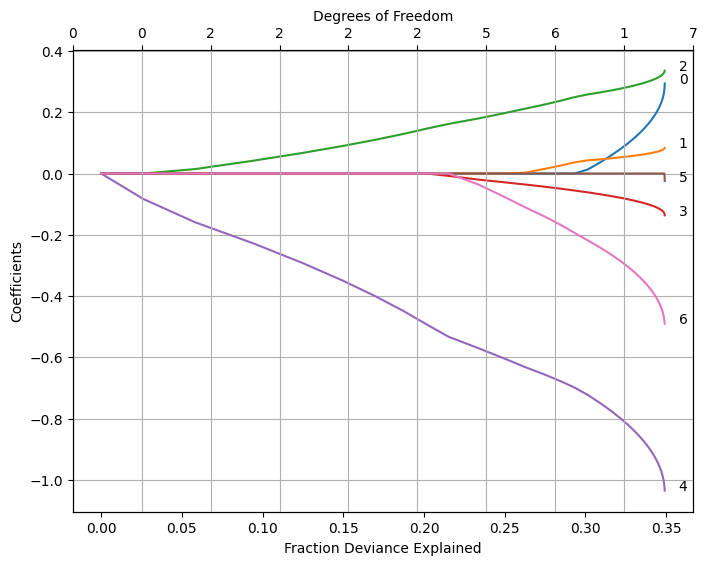

{'fig': <Figure size 800x600 with 2 Axes>,
 'ax1': <Axes: xlabel='Fraction Deviance Explained', ylabel='Coefficients'>,
 'ax2': <Axes: xlabel='Degrees of Freedom'>}

In [ ]:
import glmnet_python
from glmnet import glmnet
import sys
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

cv = glmnet(x = X.to_numpy().copy(), y = Y.to_numpy().copy(), family = 'gaussian', alpha = 1)
print('coefficients:')
coefs = glmnetCoef(cv)
print('intercept', '=', coefs[0][-1])
for i, j in enumerate(X.columns):
  print(i, ':', j, '=', coefs[i + 1][-1])
# glmnetPlot(cv['glmnet_fit'], xvar = 'lambda', label = True)
pass
plt.figure(figsize=(8, 6))
glmnetPlot(cv, label=True, xvar='dev')

There is some slight mistake in xticks above (due to python library I'm using), ignore it. From the graph above we see that Communication together with Scientific knowledge explain about 20% of deviance, whereas full model explains around 35% of deviance. This result is expected, since these 2 groups had highest absolute correlation with Overall Score.

In [ ]:
Y = df_full['Overall Score']
X = sm.add_constant(df_full[['Communication', 'Scientific knowledge']])
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     4.105
Date:                Sat, 22 Apr 2023   Prob (F-statistic):             0.0306
Time:                        23:22:13   Log-Likelihood:                 10.239
No. Observations:                  25   AIC:                            -14.48
Df Residuals:                      22   BIC:                            -10.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.7472      1.955      3.451      0.002       2.692      10.802
Communication           -0.9394      0.433     -2.169      0.041      -1.838      -0.041
Scientific knowledge     0.3234      0.171      1.886      0.073      -0.032       0.679
==============================================================================
Omnibus:                        7.499   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                5.402
Skew:                          -1.019   Prob(JB):                       0.0671
Kurtosis:                       4.016   Cond. No.                         357.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

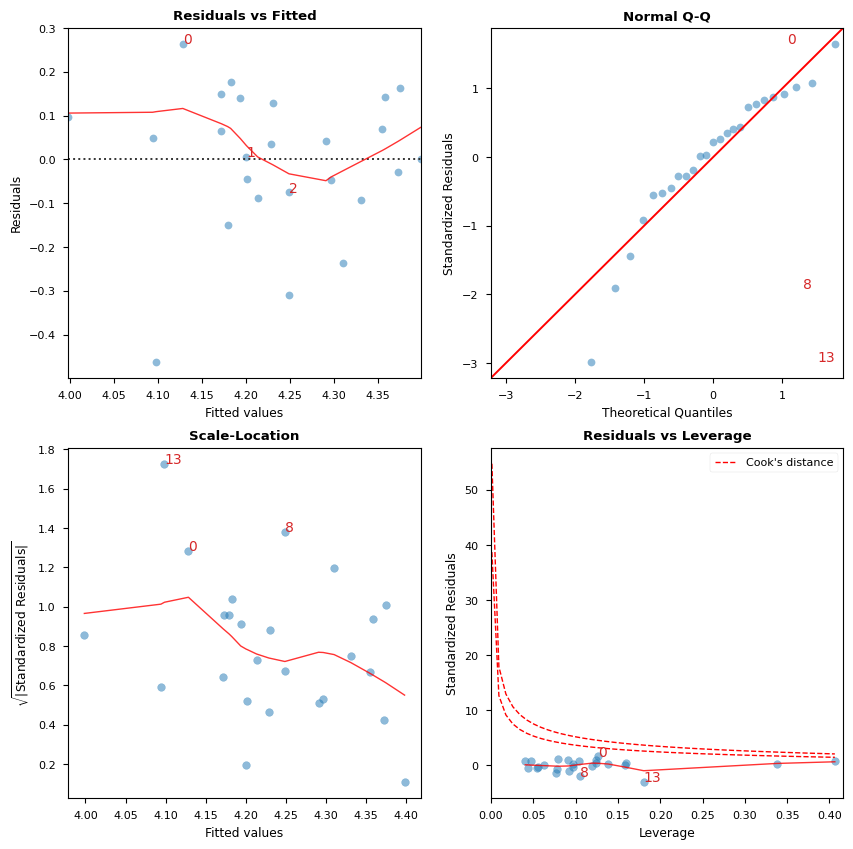

               Features  VIF Factor
2  Scientific knowledge        1.00
1         Communication        1.00
0                 const     3258.67


(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>,
         <Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>],
        [<Axes: title={'center': 'Scale-Location'}, xlabel='Fitted values', ylabel='$\\sqrt{|\\mathrm{Standardized\\ Residuals}|}$'>,
         <Axes: title={'center': 'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>]],
       dtype=object))

In [ ]:
Linear_Reg_Diagnostic(results)()

As expected, AIC score improved from -7 to -14, BIC score improved from 2 to -10 and condition number decreased from 1270 to 357. Adjusted R2 improved from 0.087 to 0.2

[]

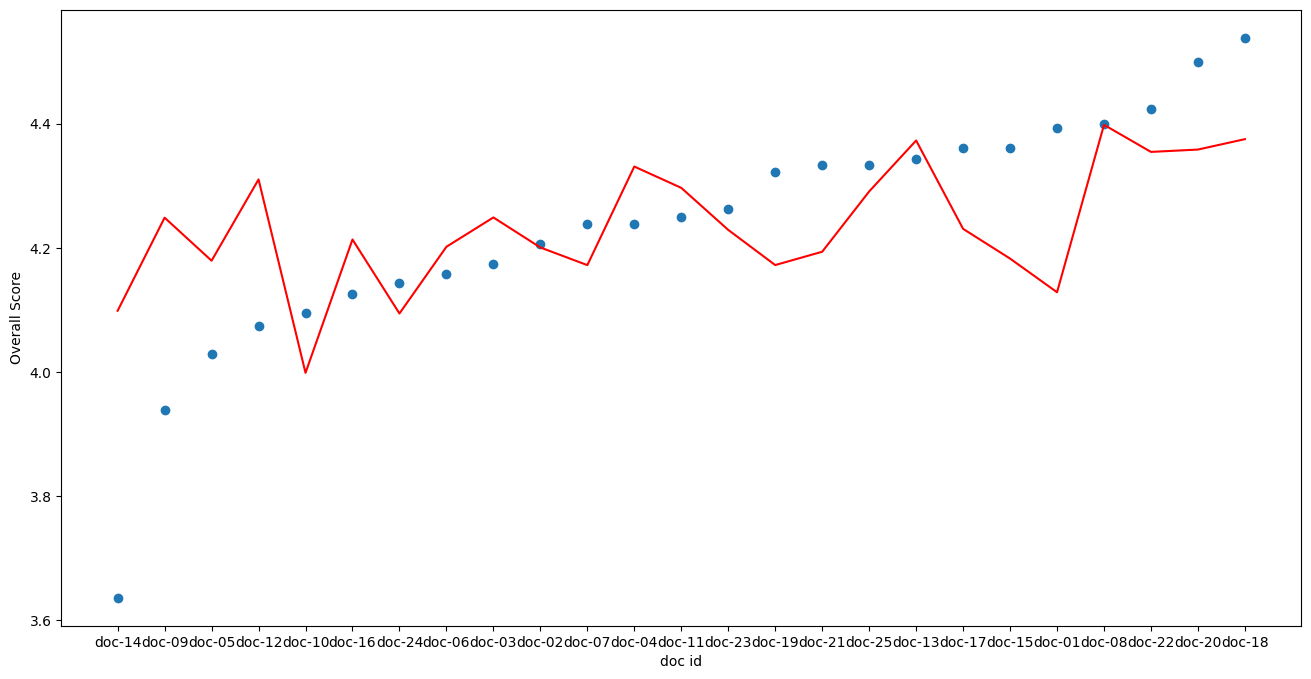

In [ ]:
plt.figure(figsize=(16,8))
y_pred = results.predict(X)
ordering = Y.sort_values().index
plt.plot(y_pred[ordering], color='r', label='OLS')
plt.scatter(Y[ordering].index, Y[ordering].values)
plt.xlabel('doc id')
plt.ylabel('Overall Score')
plt.plot()

From this graph, we can see one notable outlier, which is doc-14. It is the minimum value in our dataset, so it's predictable that this datapoint is poorly fitted.

Now let's try to predict Q23 directly from other questions, without grouping them. 

First, let's group by physician. We should have a problem of overfitting: 25 physicians and 22 features.

In [ ]:
# OLS

X = df_eval360.groupby('DocID').mean()
Y = X['Q23']
X = X.drop(columns=['Q23'])
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
results.summary()

<ipython-input-66-1ab1e0b39f0f>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  X = df_eval360.groupby('DocID').mean()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Q23   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4.248
Date:                Sat, 22 Apr 2023   Prob (F-statistic):              0.208
Time:                        23:22:15   Log-Likelihood:                 54.595
No. Observations:                  25   AIC:                            -63.19
Df Residuals:                       2   BIC:                            -35.16
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7596     29.543      1.684      0.234     -77.353     176.872
Q1             0.0330      0.413      0.080      0.943      -1.743       1.809
Q2             0.0105      0.483      0.022      0.985      -2.068       2.089
Q3             0.2191      0.331      0.661      0.576      -1.207       1.645
Q4            -2.0252      0.693     -2.922      0.100      -5.007       0.957
Q5             1.8772      0.755      2.488      0.131      -1.369       5.124
Q6             0.2203      0.332      0.663      0.576      -1.210       1.650
Q7            -0.8690      0.450     -1.930      0.193      -2.807       1.069
Q8            -0.8586      0.889     -0.966      0.436      -4.683       2.966
Q9            -2.0297      1.262     -1.609      0.249      -7.458       3.399
Q10           -0.5960      0.234     -2.550      0.125      -1.602       0.410
Q11            1.8167      1.361      1.335      0.313      -4.037       7.670
Q12            0.2109      0.706      0.299      0.793      -2.825       3.247
Q13           -0.4573      0.737     -0.620      0.598      -3.628       2.714
Q14           -2.1207      0.632     -3.353      0.079      -4.842       0.600
Q15            1.5514      0.771      2.013      0.182      -1.765       4.868
Q16           -2.1765      1.381     -1.577      0.256      -8.117       3.764
Q17           -2.5084      2.262     -1.109      0.383     -12.240       7.224
Q18           -1.0511      1.084     -0.970      0.434      -5.715       3.613
Q19           -1.6043      1.096     -1.464      0.281      -6.319       3.110
Q20            0.3158      0.498      0.635      0.591      -1.825       2.457
Q21           -1.7927      0.617     -2.905      0.101      -4.448       0.862
Q22            0.9973      0.494      2.018      0.181      -1.129       3.124
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                1.142
Skew:                           0.466   Prob(JB):                        0.565
Kurtosis:                       2.522   Cond. No.                     3.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As predicted, R2 is 0.979. Let's see if best subsets can help with that.

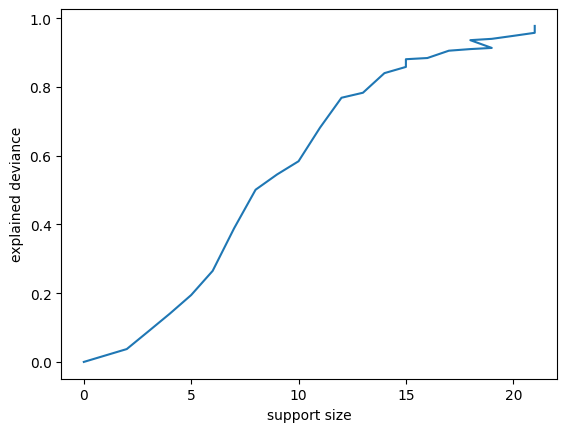

In [ ]:
cv = glmnet(x = X.to_numpy().copy(), y = Y.to_numpy().copy(), family = 'gaussian', alpha = 1)
dfs = []
devs = []
for i in range(len(cv['df'])):
  if i + 1 < len(cv['df']) and cv['df'][i] < cv['df'][i + 1]:
    dfs.append(cv['df'][i])
    devs.append(cv['dev'][i])
plt.plot(dfs, devs)
plt.xlabel('support size')
plt.ylabel('explained deviance')
plt.show()

Judging by this graph, it looks optimal to choose support size 12 to explain 80% of deviance. However, this is still too much given dataset size of 25.

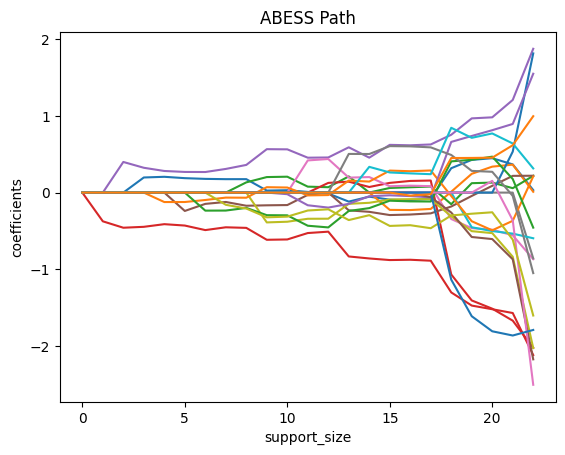

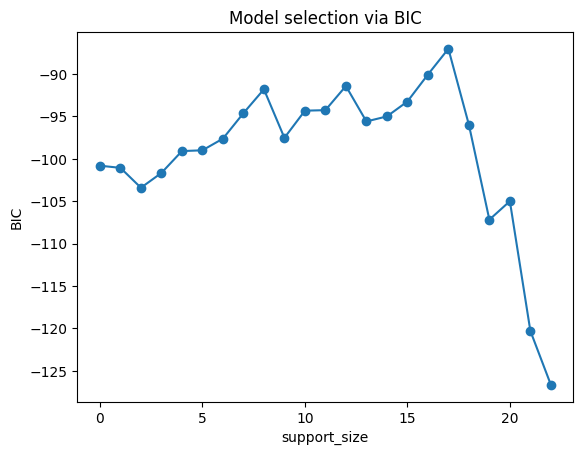

In [ ]:
max_features = len(X.columns)
coef = np.zeros((max_features + 1, max_features))
ic = np.zeros(max_features + 1)
for s in range(max_features + 1):
    model = abess.LinearRegression(support_size=s, ic_type='bic')
    model.fit(X.to_numpy(), Y.to_numpy())
    coef[s, :] = model.coef_
    ic[s] = model.ic_

for i in range(max_features):
    plt.plot(coef[:, i], label=i)

plt.xlabel('support_size')
plt.ylabel('coefficients')
plt.title('ABESS Path')
plt.show()

plt.plot(ic, 'o-')
plt.xlabel('support_size')
plt.ylabel('BIC')
plt.title('Model selection via BIC')
plt.show()

In [ ]:
X.columns[coef[3] != 0]

Index(['Q1', 'Q5', 'Q14'], dtype='object')

If we look at models with size <= 12, best subsets suggests to use model of size 3, using Q1, Q5 and Q14 to predict Q23

Let's look at correlation matrix

In [ ]:
df_eval360.groupby('DocID').mean().corr()['Q23'].sort_values()

<ipython-input-70-50de9d88e9f5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_eval360.groupby('DocID').mean().corr()['Q23'].sort_values()


Q14   -0.360202
Q12   -0.293985
Q6    -0.290094
Q13   -0.265292
Q19   -0.234647
Q3    -0.232352
Q9    -0.216267
Q15   -0.213161
Q2    -0.111839
Q22   -0.106319
Q21   -0.094859
Q8    -0.005249
Q11    0.043127
Q17    0.082214
Q10    0.085296
Q16    0.095538
Q20    0.154517
Q18    0.169632
Q4     0.186070
Q7     0.188060
Q1     0.332459
Q5     0.340684
Q23    1.000000
Name: Q23, dtype: float64

As expected, Q1 Q5 and Q14 are features with highest correlation with Q23. Let's examine one such pair: Q14 and Q23

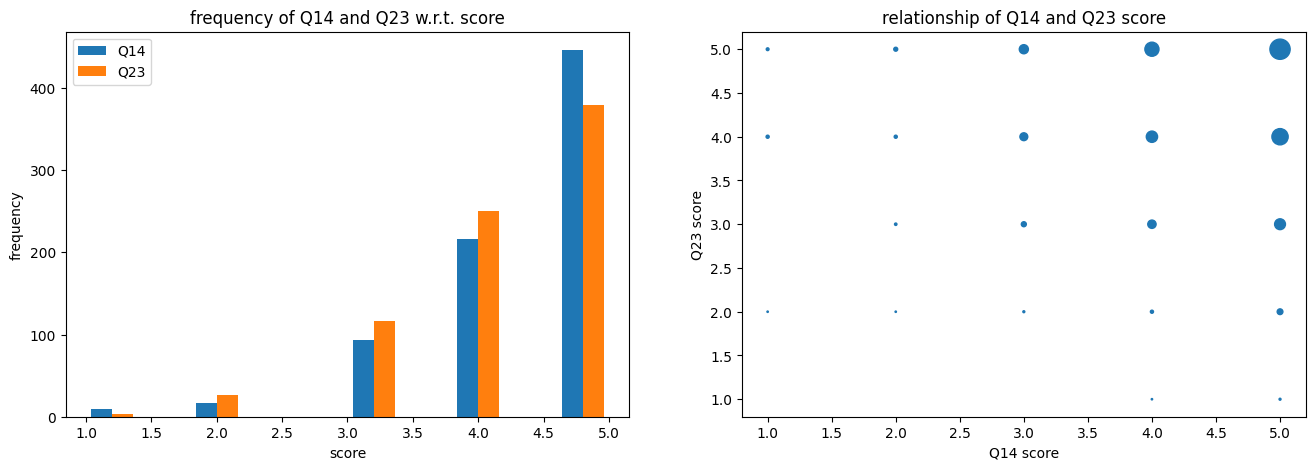

In [ ]:
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace=.4, wspace=.2)
ax = fig.add_subplot(1, 2, 1)

ax.hist(df_eval360[['Q14', 'Q23']], label=['Q14', 'Q23'])
ax.set_title('frequency of Q14 and Q23 w.r.t. score')
ax.set_xlabel('score')
ax.set_ylabel('frequency')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
z = df_eval360.groupby(['Q14', 'Q23'])['DocID'].count()
z = z.reset_index()
ax.scatter(z['Q14'], z['Q23'], s=z['DocID'])
ax.set_xlabel('Q14 score')
ax.set_ylabel('Q23 score')
ax.set_title('relationship of Q14 and Q23 score')
fig.show()

It seems like we see [Berkson's paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox). Namely, there are a lot of high scores (4-5), but almost no low scores. Let's see if this is true for other questions

<ipython-input-72-3ea0d0d4f605>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax.hist(df_eval360.mean())


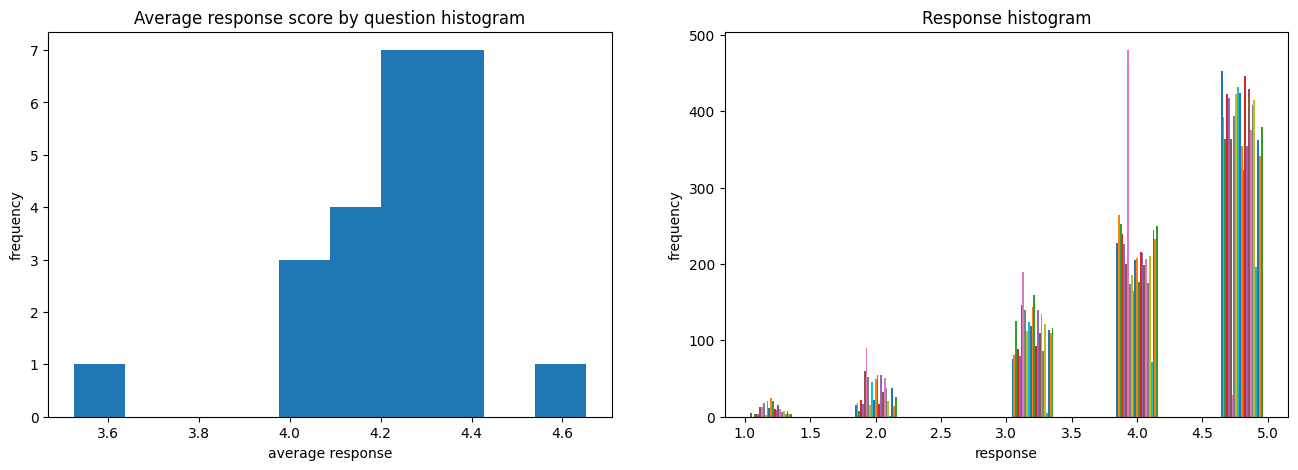

<ipython-input-72-3ea0d0d4f605>:17: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_eval360.mean().sort_values()


Q7     3.525000
Q13    3.993188
Q12    4.053915
Q6     4.075351
Q15    4.100906
Q8     4.123393
Q17    4.140464
Q10    4.193139
Q21    4.201835
Q23    4.260982
Q16    4.263359
Q22    4.278571
Q3     4.280212
Q11    4.287724
Q19    4.291613
Q18    4.319776
Q4     4.357786
Q2     4.365079
Q9     4.368564
Q14    4.369565
Q5     4.393001
Q1     4.423423
Q20    4.652174
dtype: float64

In [ ]:
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace=.4, wspace=.2)
ax = fig.add_subplot(1, 2, 1)

ax.hist(df_eval360.mean())
ax.set_xlabel('average response')
ax.set_ylabel('frequency')
ax.set_title('Average response score by question histogram')

ax = fig.add_subplot(1, 2, 2)
ax.hist(df_eval360.drop(columns=['DocID', 'position']))
ax.set_xlabel('response')
ax.set_ylabel('frequency')
ax.set_title('Response histogram')
plt.show()

df_eval360.mean().sort_values()

With the exception of Q7 and Q20, all questions have average response score between 4 and 4.43

For the fact that scores are generally high, I have 2 hypothesis:

* People usually tend to rate people they know higher on average. In other words, you will rarely score someone you know with the lowest possible score.
* This is survey about physicians, who most likely have high reputation, otherwise they wouldn't hold their position of a physician at ICU. Therefore, these people indeed should be ranked higher on average.
* It may be combination of both: subordinates are scared/respectable of their supervisors.

In response histogram, I see spike at score 4, lets' find this question.

In [ ]:
(df_eval360 == 4).sum().sort_values()

position      0
DocID         0
Q20          71
Q10         165
Q8          174
Q18         175
Q13         177
Q9          186
Q16         199
Q6          200
Q11         205
Q17         206
Q12         208
Q19         210
Q15         214
Q14         216
Q5          226
Q1          228
Q22         233
Q4          239
Q21         244
Q23         250
Q3          252
Q2          264
Q7          480
dtype: int64

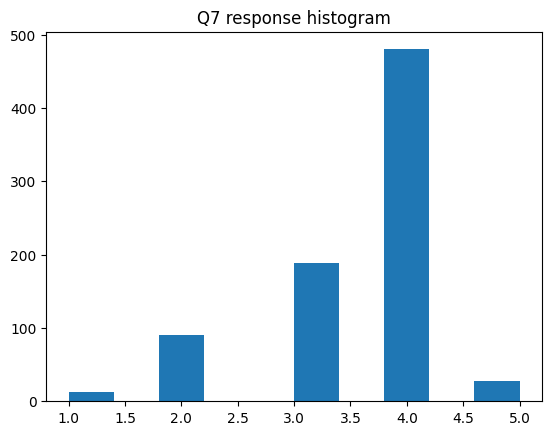

In [ ]:
plt.hist(df_eval360['Q7'])
plt.title('Q7 response histogram')
plt.show()

It is Q7 again.

It is funny that Q7 (Demonstrates honesty and integrity) has lowest average score of 3.525 and is the only question that was answered by all respondents. Looks like low average score may be explained by the fact that highest score of 5 is very rare, and people instead put 4. 

I think that there are always honesty and integrity issues in any competitive job, so there may be a reasonable explanation to that.

<ipython-input-75-cd9662df0e0a>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.hist(df_eval360.var())


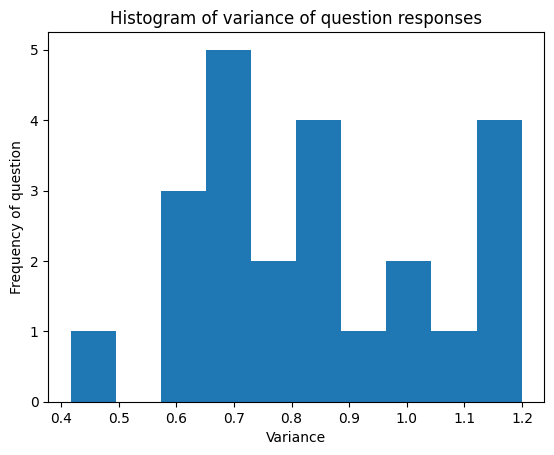

<ipython-input-75-cd9662df0e0a>:6: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_eval360.var().sort_values()


Q20    0.416759
Q2     0.589719
Q1     0.641358
Q7     0.642678
Q5     0.653967
Q3     0.662068
Q22    0.684805
Q4     0.691412
Q9     0.699797
Q23    0.741632
Q14    0.755692
Q19    0.808909
Q21    0.859472
Q11    0.863332
Q18    0.880746
Q16    0.963675
Q17    1.016373
Q15    1.020893
Q6     1.103011
Q10    1.143312
Q8     1.148204
Q12    1.166755
Q13    1.199135
dtype: float64

In [ ]:
plt.hist(df_eval360.var())
plt.title('Histogram of variance of question responses')
plt.xlabel('Variance')
plt.ylabel('Frequency of question')
plt.show()
df_eval360.var().sort_values()

Now let's make each survey to be independent data point. This way we shouldn't have supersaturation problem.

In [ ]:
df_eval360['Q23'].value_counts()

5.0    379
4.0    250
3.0    116
2.0     26
1.0      3
Name: Q23, dtype: int64

In this case, we have discrete responds from 1 to 5, but 5 has probability of almost 50%, so I model this as a binary classification task of predicting 5 (highest score). For the sake of completeness, let's run OLS first (leave scores as is, without binarization).

In [ ]:
# OLS

# fill NAs with 0, I also tried imputing with mean just in case, but as expected it didn't get much better
eval_filled = df_eval360.fillna(0)
Y = eval_filled['Q23']
X = sm.add_constant(eval_filled.drop(columns=['Q23', 'DocID', 'position']))
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Q23   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.168
Date:                Sat, 22 Apr 2023   Prob (F-statistic):              0.269
Time:                        23:22:18   Log-Likelihood:                -1223.2
No. Observations:                 800   AIC:                             2492.
Df Residuals:                     777   BIC:                             2600.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8429      0.610      6.297      0.000       2.645       5.041
Q1            -0.0729      0.037     -1.948      0.052      -0.146       0.001
Q2             0.0021      0.033      0.065      0.948      -0.062       0.066
Q3             0.0966      0.032      3.066      0.002       0.035       0.158
Q4            -0.0096      0.037     -0.262      0.794      -0.082       0.063
Q5            -0.0005      0.030     -0.018      0.986      -0.059       0.058
Q6             0.0033      0.034      0.096      0.924      -0.063       0.070
Q7            -0.0162      0.051     -0.320      0.749      -0.116       0.083
Q8            -0.0289      0.032     -0.900      0.368      -0.092       0.034
Q9             0.0224      0.029      0.783      0.434      -0.034       0.079
Q10            0.0073      0.034      0.213      0.831      -0.060       0.075
Q11           -0.0492      0.036     -1.349      0.178      -0.121       0.022
Q12           -0.0227      0.033     -0.694      0.488      -0.087       0.041
Q13            0.0016      0.027      0.061      0.951      -0.051       0.054
Q14           -0.0157      0.038     -0.415      0.679      -0.090       0.059
Q15            0.0204      0.033      0.624      0.533      -0.044       0.085
Q16            0.0673      0.036      1.865      0.063      -0.004       0.138
Q17           -0.0158      0.033     -0.474      0.636      -0.081       0.050
Q18            0.0070      0.025      0.275      0.783      -0.043       0.057
Q19            0.0169      0.035      0.483      0.629      -0.052       0.086
Q20            0.0302      0.018      1.653      0.099      -0.006       0.066
Q21            0.0333      0.032      1.038      0.300      -0.030       0.096
Q22            0.0149      0.025      0.595      0.552      -0.034       0.064
==============================================================================
Omnibus:                      272.992   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              790.952
Skew:                          -1.717   Prob(JB):                    1.77e-172
Kurtosis:                       6.454   Cond. No.                         284.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Poor result, compared to previous R2 of 0.27

In [ ]:
# Logistic Regression

Y = (eval_filled['Q23'] == 5)
X = sm.add_constant(eval_filled.drop(columns=['Q23', 'DocID', 'position']))
model = sm.Logit(Y, X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.672523
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Q23   No. Observations:                  800
Model:                          Logit   Df Residuals:                      777
Method:                           MLE   Df Model:                           22
Date:                Sat, 22 Apr 2023   Pseudo R-squ.:                 0.02782
Time:                        23:22:18   Log-Likelihood:                -538.02
converged:                       True   LL-Null:                       -553.41
Covariance Type:            nonrobust   LLR p-value:                    0.1004
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8563      1.109     -1.673      0.094      -4.031       0.318
Q1            -0.1181      0.068     -1.736      0.083      -0.251       0.015
Q2            -0.0257      0.059     -0.438      0.662      -0.141       0.089
Q3             0.1203      0.058      2.086      0.037       0.007       0.233
Q4             0.0026      0.066      0.039      0.969      -0.127       0.132
Q5            -0.0109      0.054     -0.203      0.839      -0.116       0.094
Q6            -0.0252      0.061     -0.413      0.680      -0.145       0.095
Q7             0.0949      0.092      1.032      0.302      -0.085       0.275
Q8            -0.0964      0.058     -1.660      0.097      -0.210       0.017
Q9             0.0023      0.052      0.045      0.964      -0.099       0.103
Q10            0.0307      0.062      0.495      0.621      -0.091       0.152
Q11           -0.0666      0.066     -1.011      0.312      -0.196       0.062
Q12            0.0061      0.059      0.103      0.918      -0.109       0.122
Q13           -0.0153      0.048     -0.319      0.750      -0.110       0.079
Q14            0.0127      0.069      0.185      0.853      -0.122       0.147
Q15            0.0600      0.059      1.010      0.313      -0.056       0.176
Q16            0.1745      0.067      2.602      0.009       0.043       0.306
Q17            0.0075      0.060      0.124      0.901      -0.110       0.125
Q18            0.0582      0.046      1.270      0.204      -0.032       0.148
Q19            0.0713      0.063      1.127      0.260      -0.053       0.195
Q20            0.0588      0.033      1.783      0.075      -0.006       0.123
Q21            0.1112      0.059      1.896      0.058      -0.004       0.226
Q22            0.0329      0.045      0.727      0.467      -0.056       0.122
==============================================================================
"""

In [ ]:
print('roc auc score:', roc_auc_score(Y, results.predict(X)))
print('f1 score:', f1_score(Y, results.predict(X) >= 0.5))
print('accuracy score:', accuracy_score(Y, results.predict(X) >= 0.5))


roc auc score: 0.6129331469863812
f1 score: 0.5376955903271693
accuracy score: 0.59375


We have 10% increase in accuracy and auc roc, compared to random model. Not too much, considering that grouped prediction looked more successful.

In [ ]:
# Decision Tree Classifier
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=0.05, ccp_alpha=0.001)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=223)
clf = clf.fit(X_train, y_train)
print('roc auc, f1 score, accuracy score')
print('train dataset:', roc_auc_score(y_train, list(zip(*clf.predict_proba(X_train)))[1]), 
      f1_score(y_train, clf.predict(X_train) >= 0.5), 
      accuracy_score(y_train, clf.predict(X_train) >= 0.5))
print('test dataset:', roc_auc_score(y_test, list(zip(*clf.predict_proba(X_test)))[1]), 
      f1_score(y_test, clf.predict(X_test) >= 0.5), 
      accuracy_score(y_test, clf.predict(X_test) >= 0.5))


roc auc, f1 score, accuracy score
train dataset: 0.6016165390316205 0.483704974271012 0.5819444444444445
test dataset: 0.47693920335429774 0.39999999999999997 0.625


[]

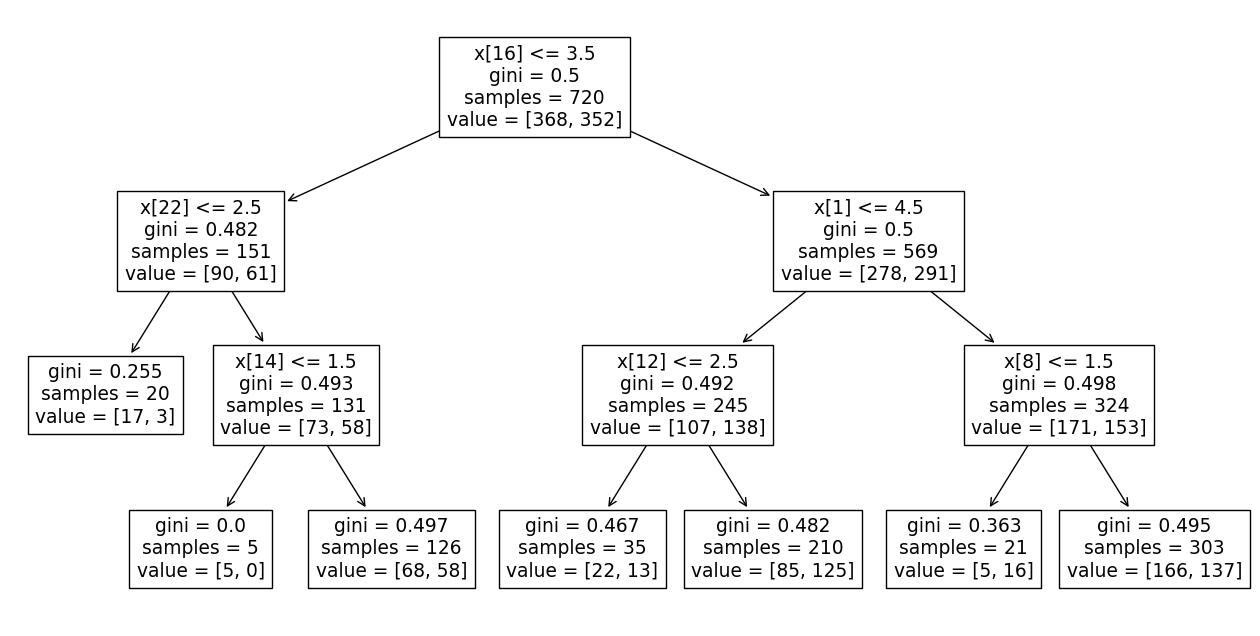

In [ ]:
plt.figure(figsize=(16,8))
tree.plot_tree(clf)
plt.plot()

In [ ]:
# Random Forest ensemble
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, oob_score=True, ccp_alpha=0.005)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=223)
clf = clf.fit(X_train, y_train)
print('roc auc, f1 score, accuracy score')
print('train dataset:', roc_auc_score(y_train, list(zip(*clf.predict_proba(X_train)))[1]), 
      f1_score(y_train, clf.predict(X_train) >= 0.5), 
      accuracy_score(y_train, clf.predict(X_train) >= 0.5))
print('test dataset:', roc_auc_score(y_test, list(zip(*clf.predict_proba(X_test)))[1]), 
      f1_score(y_test, clf.predict(X_test) >= 0.5), 
      accuracy_score(y_test, clf.predict(X_test) >= 0.5))

roc auc, f1 score, accuracy score
train dataset: 0.8431092514822136 0.7371695178849146 0.7652777777777777
test dataset: 0.5248078266946192 0.35714285714285715 0.55


Looks like logistic regression beats random forest, at least in my case. This is of course due to the fact that decision tree requires careful parameter tuning (or using special libraries for that, like xgboost for gradient boosting). On the other hand, linear regressions have advantage that they are easier to fit/interpret/tune.

I think that exploration of 360 survey on its own is enough. From results above I have a feeling that many responds are highly correlated, so it seems reasonable to return 1-2 variables from the whole survey. This way, we will not be able to interpret these values directly, but they will be enough to make decisions about explainability of target variable (that we choose later) based on 360 survey and other features. Let's use PCA.